# Skimlit Project: NLP

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts: https://arxiv.org/abs/1710.06071




# Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c40837f5-dfbc-d41a-2f38-4853a3b7faac)


# Get Helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-10 20:11:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-10 20:11:03 (72.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get the data


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.66 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in pubmed 20k

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir='pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data


In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
#let's read training data
train_lines=get_lines(data_dir+'train.txt')

In [ ]:
train_lines[:16]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

How i think the data would be best represented:

`[{'line number':0,
    'target': 'BACKGROUND',
   'text':'Emotional eating is associated with overeating and the development of obesity.\n'
   'total_lines':11},
  ...]`

In [ ]:
def text_to_listdic(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()

      #Iterate through each line in a single abstract and count them
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split('\t')
        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1 #How many total line
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples


In [ ]:
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
test_text=text_to_listdic('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
validation_text=text_to_listdic('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
train_text=text_to_listdic('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
len(train_text),len(test_text),len(validation_text)

(180040, 30135, 30212)

In [ ]:
train_text[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_text)
test_df=pd.DataFrame(test_text)
validation_df=pd.DataFrame(validation_text)

In [ ]:
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


# Visualize

<Axes: ylabel='Frequency'>

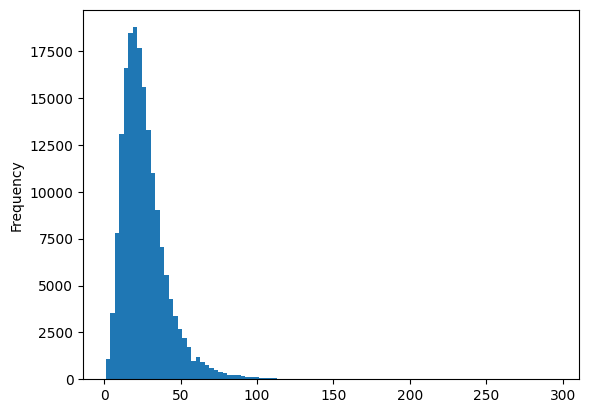

In [ ]:
train_df['text'].apply(lambda x:len(x.split())).plot.hist(bins=100)

In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: >

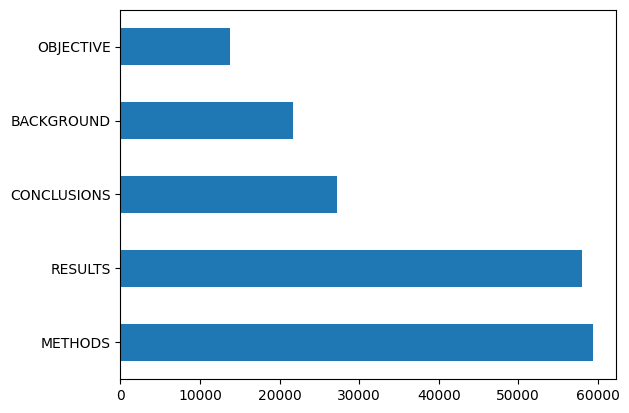

In [ ]:
train_df.target.value_counts().plot(kind='barh')

<Axes: ylabel='Frequency'>

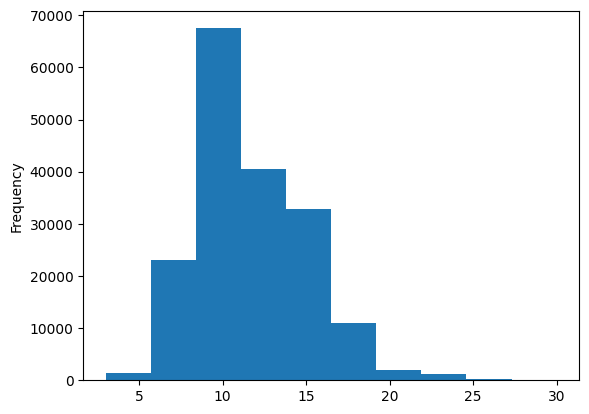

In [ ]:
# Let's check length of different lines
train_df.total_lines.plot.hist()

# Get lists of sentences

In [ ]:
train_sentences=train_df['text'].tolist()
test_sentences=test_df['text'].tolist()
validation_sentences=validation_df['text'].tolist()

In [ ]:
len(train_sentences),len(test_sentences),len(validation_sentences)

(180040, 30135, 30212)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Label Encoding

## One Hot Encoding

In [ ]:
#onehot encoding
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot_encoder=OneHotEncoder(sparse=False)  #don't want sparse matrix
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(validation_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Label encode Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(validation_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# Get class
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling Baseline

## Model 0: Baseline Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
model0=Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB())])

# Fitting the pipeline
model0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate Baseline
model0.score(validation_sentences,val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds=model0.predict(validation_sentences)
from helper_functions import calculate_results

In [ ]:
baseline_results=calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



# Preparing our data for Deep Sequence Models



In [ ]:
from tensorflow.keras.layers import TextVectorization,Embedding
import numpy as np
import tensorflow as tf

In [ ]:
sent_len=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_len)
avg_sent_len

26.338269273494777

(array([1.1050e+03, 3.5170e+03, 7.7850e+03, 1.3079e+04, 1.6589e+04,
        1.8463e+04, 1.8770e+04, 1.7656e+04, 1.5580e+04, 1.3302e+04,
        1.1002e+04, 9.0040e+03, 7.0390e+03, 5.5540e+03, 4.2780e+03,
        3.3890e+03, 2.7020e+03, 2.1960e+03, 1.7050e+03, 9.5300e+02,
        1.1780e+03, 9.0000e+02, 7.5000e+02, 6.0900e+02, 4.9400e+02,
        4.0100e+02, 3.5000e+02, 2.5000e+02, 2.2900e+02, 2.1500e+02,
        1.6700e+02, 1.2600e+02, 1.0200e+02, 1.0100e+02, 6.4000e+01,
        6.1000e+01, 5.5000e+01, 4.5000e+01, 4.0000e+01, 2.5000e+01,
        2.5000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01,
        1.0000e+01, 7.0000e+00, 1.6000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.00

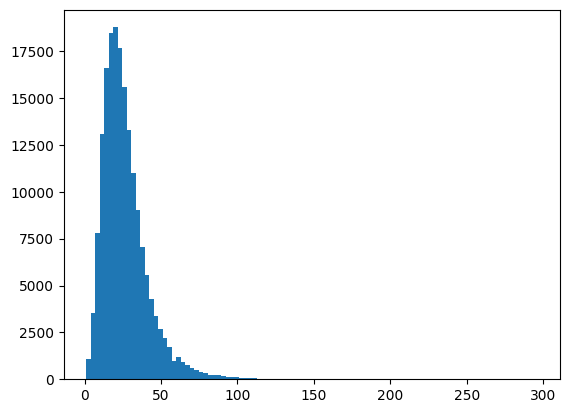

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_len,bins=100)

In [ ]:
#How long of a sentence length covers 95% of all of the sentences
output_seq_len=int(np.percentile(sent_len,95))
output_seq_len

55

In [ ]:
#max sequence length
max_len=max(sent_len)
max_len

296

In [ ]:
#Text vectorization layer
#max tokens= Number of max words in the data
# How many words in Vocab (Max tokens)? (taken from table 2 of the paper)
# Output_sequence_length= length of output sentence
max_tokens=68000
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  split='whitespace',
                                  output_sequence_length=output_seq_len)

## Text Vectorization

In [ ]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test text vectorizer on random sentences
import random
target_sentence=random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\n Vectorized text: {text_vectorizer([target_sentence])}')

Text:
 pb disappeared in @/@ and @/@ patients during @ % and @ % co@ .

Length of text: 15

 Vectorized text: [[5810 7549    5    3   12   52    3 1336    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary()

In [ ]:
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Embedding layer

In [ ]:
output_dim=128 #Use size according to dataset
#input_dims=Vocab length
#mask_zero saves space by masking 0 values out with are padding
embedding=Embedding(input_dim=len(rct_20k_text_vocab),output_dim=output_dim,
                    mask_zero=True,name='token_embedding')

In [ ]:
print(f'Sentence before vectorization:\n {target_sentence}')
vectorized_sentence=text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}')
embedded_sentence=embedding(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f'Shape after embedding:\n {embedded_sentence.shape}')

Sentence before vectorization:
 pb disappeared in @/@ and @/@ patients during @ % and @ % co@ .
Sentence after vectorization:
 [[5810 7549    5    3   12   52    3 1336    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
 [[[-0.04348981 -0.03260082 -0.01780052 ...  0.02800348 -0.00145763
   -0.02416396]
  [ 0.00234377  0.00950231 -0.04797591 ... -0.01890527 -0.02974372
   -0.01572973]
  [ 0.01156509 -0.03179067  0.04053396 ... -0.02301928  0.03857999
   -0.04872985]
  ...
  [-0.03553303  0.00972471 -0.03355676 ...  0.01851893  0.01528204
   -0.00748451]
  [-0.03553303  0.00972471 -0.03355676 ...  0.01851893  0.01528204
   -0.00748451]
  [-0.03553303  0.00972471 -0.03355676 ...  0.01851893  0.01528204
   -0.00748451]]]
Shape after embedding:
 (1, 55, 128)


# Creating datasets (make data pipeline as fast as possible)

In [ ]:
import tensorflow as tf

In [ ]:
# Turn our data into tensorflow dataets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((validation_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
# Take the tensorflow datasets batch and prefetch them
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Modelling PT2

## Model 1: Conv1D

In [ ]:
inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,))

x=text_vectorizer(inputs)
x=embedding(x)

x=tf.keras.layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model1=tf.keras.Model(inputs,outputs)

In [ ]:
model1.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history1=model1.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
1125/1125 [==============================] - 48s 40ms/step - loss: 0.7077 - accuracy: 0.7346 - val_loss: 0.5406 - val_accuracy: 0.7992
Epoch 2/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5329 - accuracy: 0.8040 - val_loss: 0.5206 - val_accuracy: 0.8059
Epoch 3/5
1125/1125 [==============================] - 12s 11ms/step - loss: 0.5265 - accuracy: 0.8083 - val_loss: 0.4944 - val_accuracy: 0.8205
Epoch 4/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.4889 - accuracy: 0.8202 - val_loss: 0.4724 - val_accuracy: 0.8238
Epoch 5/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.4887 - accuracy: 0.8226 - val_loss: 0.4868 - val_accuracy: 0.8188


In [ ]:
# evaluate
model1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4784 - accuracy: 0.8263


[0.4783860146999359, 0.8262611031532288]

In [ ]:
model1_pred_probs=model1.predict(val_dataset)
model1_pred=tf.argmax(model1_pred_probs,axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model1_results=calculate_results(val_labels_encoded,model1_pred)

In [ ]:
model1_results

{'accuracy': 82.62610883092812,
 'precision': 0.8247364562992142,
 'recall': 0.8262610883092811,
 'f1': 0.823204008268439}

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model1_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3449
           1       0.77      0.74      0.75      4582
           2       0.90      0.90      0.90      9964
           3       0.77      0.53      0.63      2376
           4       0.85      0.92      0.88      9841

    accuracy                           0.83     30212
   macro avg       0.79      0.75      0.77     30212
weighted avg       0.82      0.83      0.82     30212



## Model 2: Feature extraction with pretrained embedding

Universal Sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4


In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='universal_sentence_encoder')

In [ ]:
# Test pretrained embeddings

random_train_sentence=random.choice(train_sentences)
print(f'Random Sentence:\n {random_train_sentence}')
embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {embedded_sentence[:,:30]}")
print(f'Shape after embedding:\n {embedded_sentence.shape}')

Random Sentence:
 the major side-effect of photodynamic therapy ( pdt ) on port wine stains ( pws ) is pain during the treatment .
Sentence after embedding:
 [[-0.00691889  0.05927906 -0.01370339  0.01209668 -0.05058596 -0.04860718
  -0.03462902 -0.02713635  0.05847441  0.00535259  0.06945384 -0.00038091
  -0.07440024  0.06104896 -0.04148382  0.02081693 -0.08014298  0.0070477
   0.01759369  0.03334543 -0.0784737   0.07651568  0.05115767 -0.07400729
   0.07998642  0.00725789  0.01943894 -0.05473882 -0.03625854 -0.06238095]]
Shape after embedding:
 (1, 512)


In [ ]:
inputs=tf.keras.layers.Input(dtype=tf.string,shape=[])

x=tf_hub_embedding_layer(inputs)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model2=tf.keras.Model(inputs,outputs)

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                           

In [ ]:
model2.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history2=model2.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
1125/1125 [==============================] - 21s 15ms/step - loss: 0.7997 - accuracy: 0.6894 - val_loss: 0.6983 - val_accuracy: 0.7287
Epoch 2/5
1125/1125 [==============================] - 17s 15ms/step - loss: 0.6871 - accuracy: 0.7364 - val_loss: 0.6530 - val_accuracy: 0.7513
Epoch 3/5
1125/1125 [==============================] - 27s 24ms/step - loss: 0.6779 - accuracy: 0.7384 - val_loss: 0.6338 - val_accuracy: 0.7573
Epoch 4/5
1125/1125 [==============================] - 16s 14ms/step - loss: 0.6423 - accuracy: 0.7530 - val_loss: 0.6198 - val_accuracy: 0.7666
Epoch 5/5
1125/1125 [==============================] - 16s 14ms/step - loss: 0.6363 - accuracy: 0.7577 - val_loss: 0.6188 - val_accuracy: 0.7620


In [ ]:
model2.evaluate(val_dataset)

In [ ]:
model2_pred_probs=model2.predict(val_dataset)
model2_pred=tf.argmax(model2_pred_probs,axis=1)

In [ ]:
model2_results=calculate_results(val_labels_encoded,model2_pred)

In [ ]:
model2_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model2_pred))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      3449
           1       0.67      0.63      0.65      4582
           2       0.84      0.83      0.84      9964
           3       0.70      0.50      0.58      2376
           4       0.78      0.88      0.83      9841

    accuracy                           0.76     30212
   macro avg       0.72      0.69      0.70     30212
weighted avg       0.76      0.76      0.76     30212



## Model 3: Conv1D with character embeddings


### Character-level tokenizer

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in validation_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_len=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_len)
mean_char_len

149.3662574983337

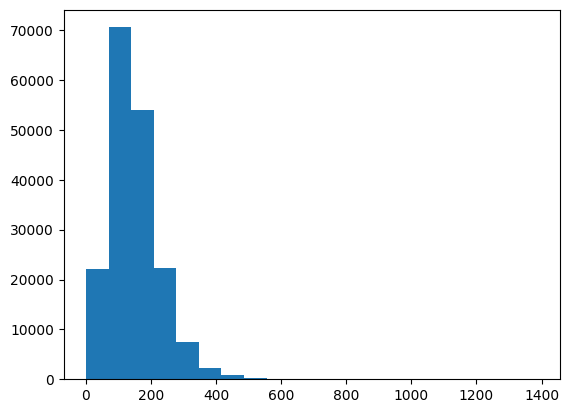

In [ ]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(char_len,bins=20);

In [ ]:
#find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_len,95))

In [ ]:
output_seq_char_len

290

In [ ]:
#number of alphanumeric characters: there are punctuations and > < signs
#otherwise alpha was sufficient
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
random.choice(train_sentences)

'to determine the effect of ranolazine , an anti-ischaemic agent with anti-arrhythmic properties , on the overall burden of atrial fibrillation ( af ) in acute coronary syndromes ( acs ) and determine whether ranolazine reduces the long-term incidence of clinical af after acs .'

In [ ]:
num_char_tokens=len(alphabet) + 2 # add for space and UNK

In [ ]:
char_vectorizer=TextVectorization(max_tokens=num_char_tokens,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
#check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 Most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars=random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars=char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n {vectorized_chars}')
print(f' Length of Vectorized chars:\n {len(vectorized_chars[0])}')

Charified text:
 t h e   i n t e n t i o n   t o   t r e a t   (   i t t   )   p o p u l a t i o n   w a s   c o m p r i s e d   o f   @   p a t i e n t s   (   s o x   a r m   :   @   a n d   c a p e o x   a r m   :   @   )   .
Length of random_train_chars: 82
Vectorized chars:
 [[ 3 13  2  4  6  3  2  6  3  4  7  6  3  7  3  8  2  5  3  4  3  3 14  7
  14 16 12  5  3  4  7  6 20  5  9 11  7 15 14  8  4  9  2 10  7 17 14  5
   3  4  2  6  3  9  9  7 24  5  8 15  5  6 10 11  5 14  2  7 24  5  8 15
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Character-level embedding

In [ ]:
output_dim=25 #Use size according to dataset
#input_dims=Vocab length
#mask_zero saves space by masking 0 values out with are padding
char_embedding=Embedding(input_dim=len(char_vocab),
                         output_dim=output_dim,
                         mask_zero=True,
                         name='char_embedding')

In [ ]:
random_train_chars=random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
embedded_chars=char_embedding(char_vectorizer([random_train_chars]))
print(f'Embedded chars:\n {embedded_chars}')
print(f'shape of embedded chars:\n {embedded_chars.shape}')

Charified text:
 r e p e a t e d   m e a s u r e s   l o n g i t u d i n a l   l i n e a r   r e g r e s s i o n   w i t h   i m p u t a t i o n   o f   m i s s i n g   o b s e r v a t i o n s   w a s   u s e d   t o   c o m p a r e   c h a n g e s   i n   b o d y   w e i g h t   .
Length of random_train_chars: 115
Embedded chars:
 [[[-2.9042412e-02 -2.5512464e-03  1.1314355e-02 ... -2.1550430e-02
   -4.5178559e-02  1.3876710e-02]
  [-1.2052059e-04 -1.1937164e-02  3.8774144e-02 ... -3.1238461e-02
   -4.3244507e-02 -2.2423757e-02]
  [ 2.2315908e-02  1.5188981e-02 -9.4532967e-05 ...  9.4314441e-03
   -2.3273552e-02  2.5353257e-02]
  ...
  [-7.1479082e-03 -2.7425433e-02  3.1244088e-02 ...  3.7505161e-02
    7.7330582e-03 -3.8177419e-02]
  [-7.1479082e-03 -2.7425433e-02  3.1244088e-02 ...  3.7505161e-02
    7.7330582e-03 -3.8177419e-02]
  [-7.1479082e-03 -2.7425433e-02  3.1244088e-02 ...  3.7505161e-02
    7.7330582e-03 -3.8177419e-02]]]
shape of embedded chars:
 (1, 290, 25)


## Model 3: Conv1D on character embeddings

In [ ]:
import tensorflow as tf
inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,))

x=char_vectorizer(inputs)
x=char_embedding(x)

x=tf.keras.layers.Conv1D(64,kernel_size=3,padding='same',activation='relu')(x)
x=tf.keras.layers.Conv1D(64,kernel_size=3,padding='same',activation='relu')(x)
x=tf.keras.layers.Conv1D(64,kernel_size=3,padding='same',activation='relu')(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model3=tf.keras.Model(inputs,outputs)

In [ ]:
model3.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model3.summary()

In [ ]:
#char level datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history3=model3.fit(train_char_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.10*len(train_dataset)),
                    validation_data=val_char_dataset,
                    validation_steps=int(0.1*len(val_char_dataset)))

In [ ]:
model3.evaluate(val_char_dataset)

In [ ]:
model_3_pred_probs=model3.predict(val_char_dataset)
model3_preds=tf.argmax(model_3_pred_probs,axis=1)
model3_results=calculate_results(val_labels_encoded,model3_preds)

In [ ]:
model3_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model3_preds))

              precision    recall  f1-score   support

           0       0.42      0.51      0.46      3449
           1       0.50      0.65      0.56      4582
           2       0.79      0.82      0.81      9964
           3       0.68      0.53      0.59      2376
           4       0.87      0.70      0.78      9841

    accuracy                           0.70     30212
   macro avg       0.65      0.64      0.64     30212
weighted avg       0.72      0.70      0.70     30212



## Model4: Bi-GRU model on character embeddings

In [ ]:
inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,))

x=char_vectorizer(inputs)
x=char_embedding(x)

x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(x)

outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model4=tf.keras.Model(inputs,outputs)

In [ ]:
model4.summary()

In [ ]:
model4.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history4=model4.fit(train_char_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_char_dataset)),
                    validation_data=val_char_dataset,
                    validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
1125/1125 [==============================] - 145s 107ms/step - loss: 1.2043 - accuracy: 0.5027 - val_loss: 1.0140 - val_accuracy: 0.5871
Epoch 2/5
1125/1125 [==============================] - 106s 95ms/step - loss: 0.9324 - accuracy: 0.6294 - val_loss: 0.8195 - val_accuracy: 0.6672
Epoch 3/5
1125/1125 [==============================] - 103s 92ms/step - loss: 0.8070 - accuracy: 0.6859 - val_loss: 0.7473 - val_accuracy: 0.7048
Epoch 4/5
1125/1125 [==============================] - 120s 107ms/step - loss: 0.7314 - accuracy: 0.7178 - val_loss: 0.7053 - val_accuracy: 0.7311
Epoch 5/5
1125/1125 [==============================] - 119s 106ms/step - loss: 0.6948 - accuracy: 0.7341 - val_loss: 0.6580 - val_accuracy: 0.7473


In [ ]:
model4.evaluate(val_char_dataset)

945/945 [==============================] - 28s 29ms/step - loss: 0.6701 - accuracy: 0.7427


[0.6701401472091675, 0.7427181005477905]

In [ ]:
from helper_functions import calculate_results
model_4_pred_probs=model4.predict(val_char_dataset)
model4_preds=tf.argmax(model_4_pred_probs,axis=1)
model4_results=calculate_results(val_labels_encoded,model4_preds)

In [ ]:
model4_results

{'accuracy': 74.27181252482458,
 'precision': 0.7403437392097815,
 'recall': 0.7427181252482458,
 'f1': 0.7361266259456871}

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model4_preds))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55      3449
           1       0.66      0.49      0.56      4582
           2       0.80      0.87      0.83      9964
           3       0.75      0.48      0.59      2376
           4       0.79      0.85      0.82      9841

    accuracy                           0.74     30212
   macro avg       0.70      0.66      0.67     30212
weighted avg       0.74      0.74      0.74     30212



## Model 5: using bidirectional GRU with Token Embedding

In [ ]:
inputs=tf.keras.layers.Input(dtype=tf.string,shape=[])

x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(x)
outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model5=tf.keras.Model(inputs,outputs)

In [ ]:
model5.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history5=model5.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
1125/1125 [==============================] - 106s 73ms/step - loss: 0.5309 - accuracy: 0.8037 - val_loss: 0.5040 - val_accuracy: 0.8055
Epoch 2/5
1125/1125 [==============================] - 51s 45ms/step - loss: 0.4375 - accuracy: 0.8400 - val_loss: 0.4792 - val_accuracy: 0.8211
Epoch 3/5
1125/1125 [==============================] - 50s 44ms/step - loss: 0.4434 - accuracy: 0.8385 - val_loss: 0.4728 - val_accuracy: 0.8238
Epoch 4/5
1125/1125 [==============================] - 52s 46ms/step - loss: 0.4155 - accuracy: 0.8496 - val_loss: 0.4744 - val_accuracy: 0.8348
Epoch 5/5
1125/1125 [==============================] - 50s 45ms/step - loss: 0.4158 - accuracy: 0.8479 - val_loss: 0.4806 - val_accuracy: 0.8255


In [ ]:
model5.evaluate(val_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.4783 - accuracy: 0.8247


[0.47833526134490967, 0.8247054219245911]

In [ ]:
model5_pred_probs=model5.predict(val_dataset)
model5_pred=tf.argmax(model5_pred_probs,axis=1)
model5_results=calculate_results(val_labels_encoded,model5_pred)

945/945 [==============================] - 18s 12ms/step


In [ ]:
model5_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model5_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      3449
           1       0.77      0.75      0.76      4582
           2       0.91      0.87      0.89      9964
           3       0.77      0.54      0.64      2376
           4       0.84      0.92      0.88      9841

    accuracy                           0.82     30212
   macro avg       0.79      0.76      0.77     30212
weighted avg       0.83      0.82      0.82     30212



## Model 6: Using Transformer model BERT


In [ ]:
# !pip uninstall -y -q tensorflow-text
# # !pip install -q -U "tensorflow-text==2.10.*"

!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_text
import tensorflow_hub as hub
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",
    trainable=False)

In [ ]:
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)

x= preprocessor(inputs)
x = encoder(x)
x = x["pooled_output"]
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)

outputs=tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model6=tf.keras.Model(inputs,outputs)

In [ ]:
model6.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model6.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_6[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
history6=model6.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
1125/1125 [==============================] - 207s 176ms/step - loss: 0.7336 - accuracy: 0.7096 - val_loss: 0.6192 - val_accuracy: 0.7640
Epoch 2/5
1125/1125 [==============================] - 198s 176ms/step - loss: 0.6258 - accuracy: 0.7601 - val_loss: 0.6054 - val_accuracy: 0.7666
Epoch 3/5
1125/1125 [==============================] - 204s 181ms/step - loss: 0.6169 - accuracy: 0.7644 - val_loss: 0.5670 - val_accuracy: 0.7733
Epoch 4/5
1125/1125 [==============================] - 199s 177ms/step - loss: 0.5836 - accuracy: 0.7793 - val_loss: 0.5548 - val_accuracy: 0.7889
Epoch 5/5
1125/1125 [==============================] - 205s 182ms/step - loss: 0.5715 - accuracy: 0.7856 - val_loss: 0.5814 - val_accuracy: 0.7849


In [ ]:
model6_pred_probs=model6.predict(val_dataset)
model6_pred=tf.argmax(model6_pred_probs,axis=1)
model6_results=calculate_results(val_labels_encoded,model6_pred)

945/945 [==============================] - 149s 158ms/step


In [ ]:
model6_results

{'accuracy': 78.7733350986363,
 'precision': 0.7827163773393625,
 'recall': 0.787733350986363,
 'f1': 0.7812368564327745}

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model6_pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      3449
           1       0.75      0.63      0.68      4582
           2       0.85      0.87      0.86      9964
           3       0.72      0.51      0.60      2376
           4       0.79      0.92      0.85      9841

    accuracy                           0.79     30212
   macro avg       0.75      0.70      0.72     30212
weighted avg       0.78      0.79      0.78     30212



## Model 7: Combining pretrained token embedding + characters embeddings (Hybrid embedding layer)



In [ ]:
# 1. Setup token input/model

token_inputs=tf.keras.layers.Input(shape=[], dtype=tf.string,name='token_input')
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model

char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')

char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)

char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(char_bi_gru1)

char_model=tf.keras.Model(char_inputs,char_bi_gru2)
# 3. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 4. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(192, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(combined_bi_gru1)

# 5. Creating output layers - adding dropout

combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)
combined_dense=tf.keras.layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 6. Construct model with char and token inputs

model7=tf.keras.Model(inputs=[token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_model')

In [ ]:
model7.summary()

Model: "Token_char_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, 290, 25)      700         ['char_vectorizer[

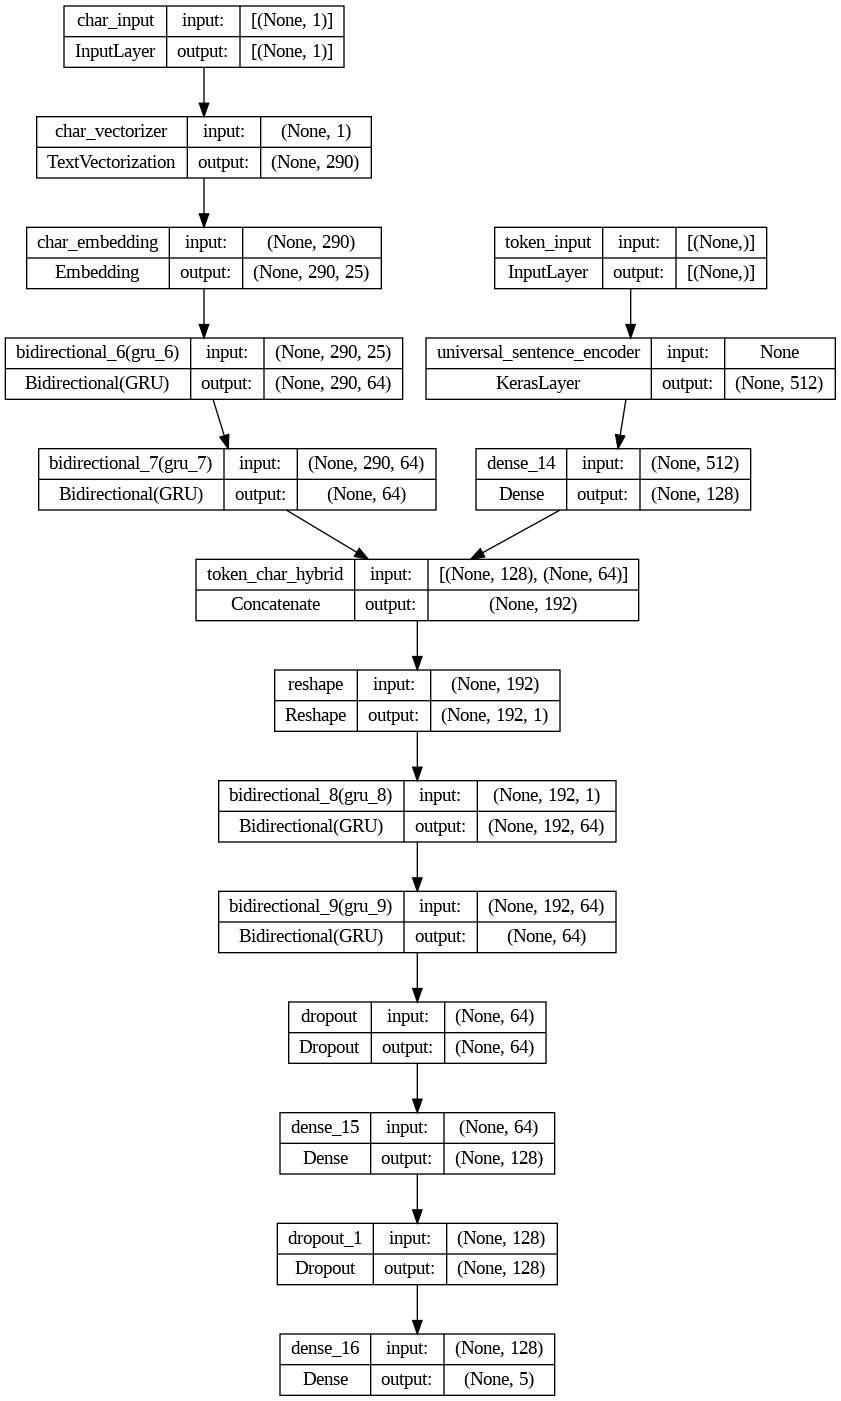

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model7,show_shapes=True)

In [ ]:
model7.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Combining token and characters data into TF Dataset

In [ ]:
# combines chars and tokens into the dataset
train_hybrid_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_hybrid_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset=tf.data.Dataset.zip((train_hybrid_data,train_hybrid_labels))
# batch and prefetch
train_hybrid_dataset=train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# combines chars and tokens into the dataset
val_hybrid_data=tf.data.Dataset.from_tensor_slices((validation_sentences,val_chars))
val_hybrid_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset=tf.data.Dataset.zip((val_hybrid_data,val_hybrid_labels))
# batch and prefetch
val_hybrid_dataset=val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



# combines chars and tokens into the dataset
test_hybrid_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_hybrid_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset=tf.data.Dataset.zip((test_hybrid_data,test_hybrid_labels))
# batch and prefetch
test_hybrid_dataset=test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
history7=model7.fit(train_hybrid_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_hybrid_dataset)),
                    validation_data=val_hybrid_dataset,
                    validation_steps=int(0.1*len(val_hybrid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 152s 114ms/step - loss: 1.0141 - accuracy: 0.5566 - val_loss: 0.8032 - val_accuracy: 0.6729
Epoch 2/5
1125/1125 [==============================] - 116s 103ms/step - loss: 0.8222 - accuracy: 0.6787 - val_loss: 0.7389 - val_accuracy: 0.7045
Epoch 3/5
1125/1125 [==============================] - 109s 97ms/step - loss: 0.7970 - accuracy: 0.6964 - val_loss: 0.6981 - val_accuracy: 0.7344
Epoch 4/5
1125/1125 [==============================] - 123s 110ms/step - loss: 0.7426 - accuracy: 0.7232 - val_loss: 0.6657 - val_accuracy: 0.7527
Epoch 5/5
1125/1125 [==============================] - 121s 108ms/step - loss: 0.7258 - accuracy: 0.7306 - val_loss: 0.6624 - val_accuracy: 0.7430


In [ ]:
model7_pred_probs=model7.predict(val_hybrid_dataset)
model7_pred=tf.argmax(model7_pred_probs,axis=1)
model7_results=calculate_results(val_labels_encoded,model7_pred)

945/945 [==============================] - 42s 38ms/step


In [ ]:
model7_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model7_pred))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54      3449
           1       0.61      0.64      0.62      4582
           2       0.82      0.84      0.83      9964
           3       0.74      0.50      0.60      2376
           4       0.79      0.85      0.82      9841

    accuracy                           0.75     30212
   macro avg       0.71      0.66      0.68     30212
weighted avg       0.74      0.75      0.74     30212



## Model 8: Char embeddings & Token embeddings & Positional embeddings


In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings


In [ ]:
# How many different line numbers are there

train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

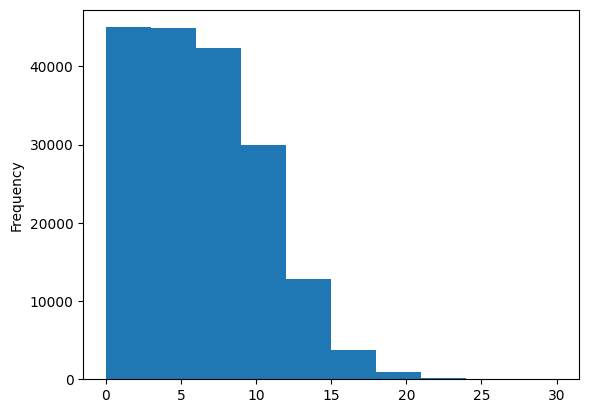

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
# Use tensorflow to create One-hot-encoded tensors for line number
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(validation_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

In [ ]:
# Using until line 15 covers 98% of the data so it should be fine
int(np.percentile(train_df['line_number'],98)),int(np.percentile(validation_df['line_number'],98))

(15, 15)

In [ ]:
train_line_numbers_one_hot[:5],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

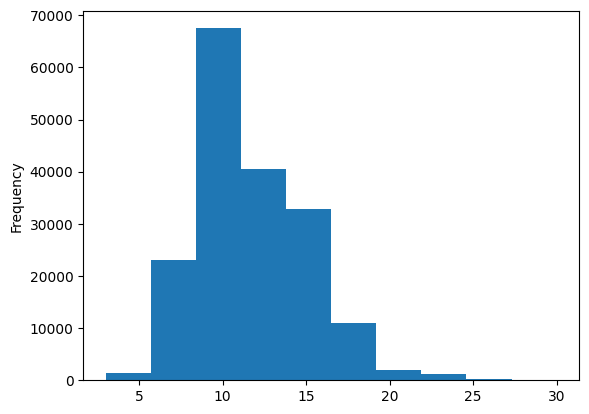

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
int(np.percentile(train_df['total_lines'],98))

20

In [ ]:
# Use tensorflow to create One-hot-encoded tensors for total lines
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(validation_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

In [ ]:
train_total_lines_one_hot[:5],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

### Building the tribrid embedding model



In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=[], dtype=tf.string,name='token_input')
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(char_bi_gru1)
char_model=tf.keras.Model(char_inputs,char_bi_gru2)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(32,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(192, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(combined_bi_gru1)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model8=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

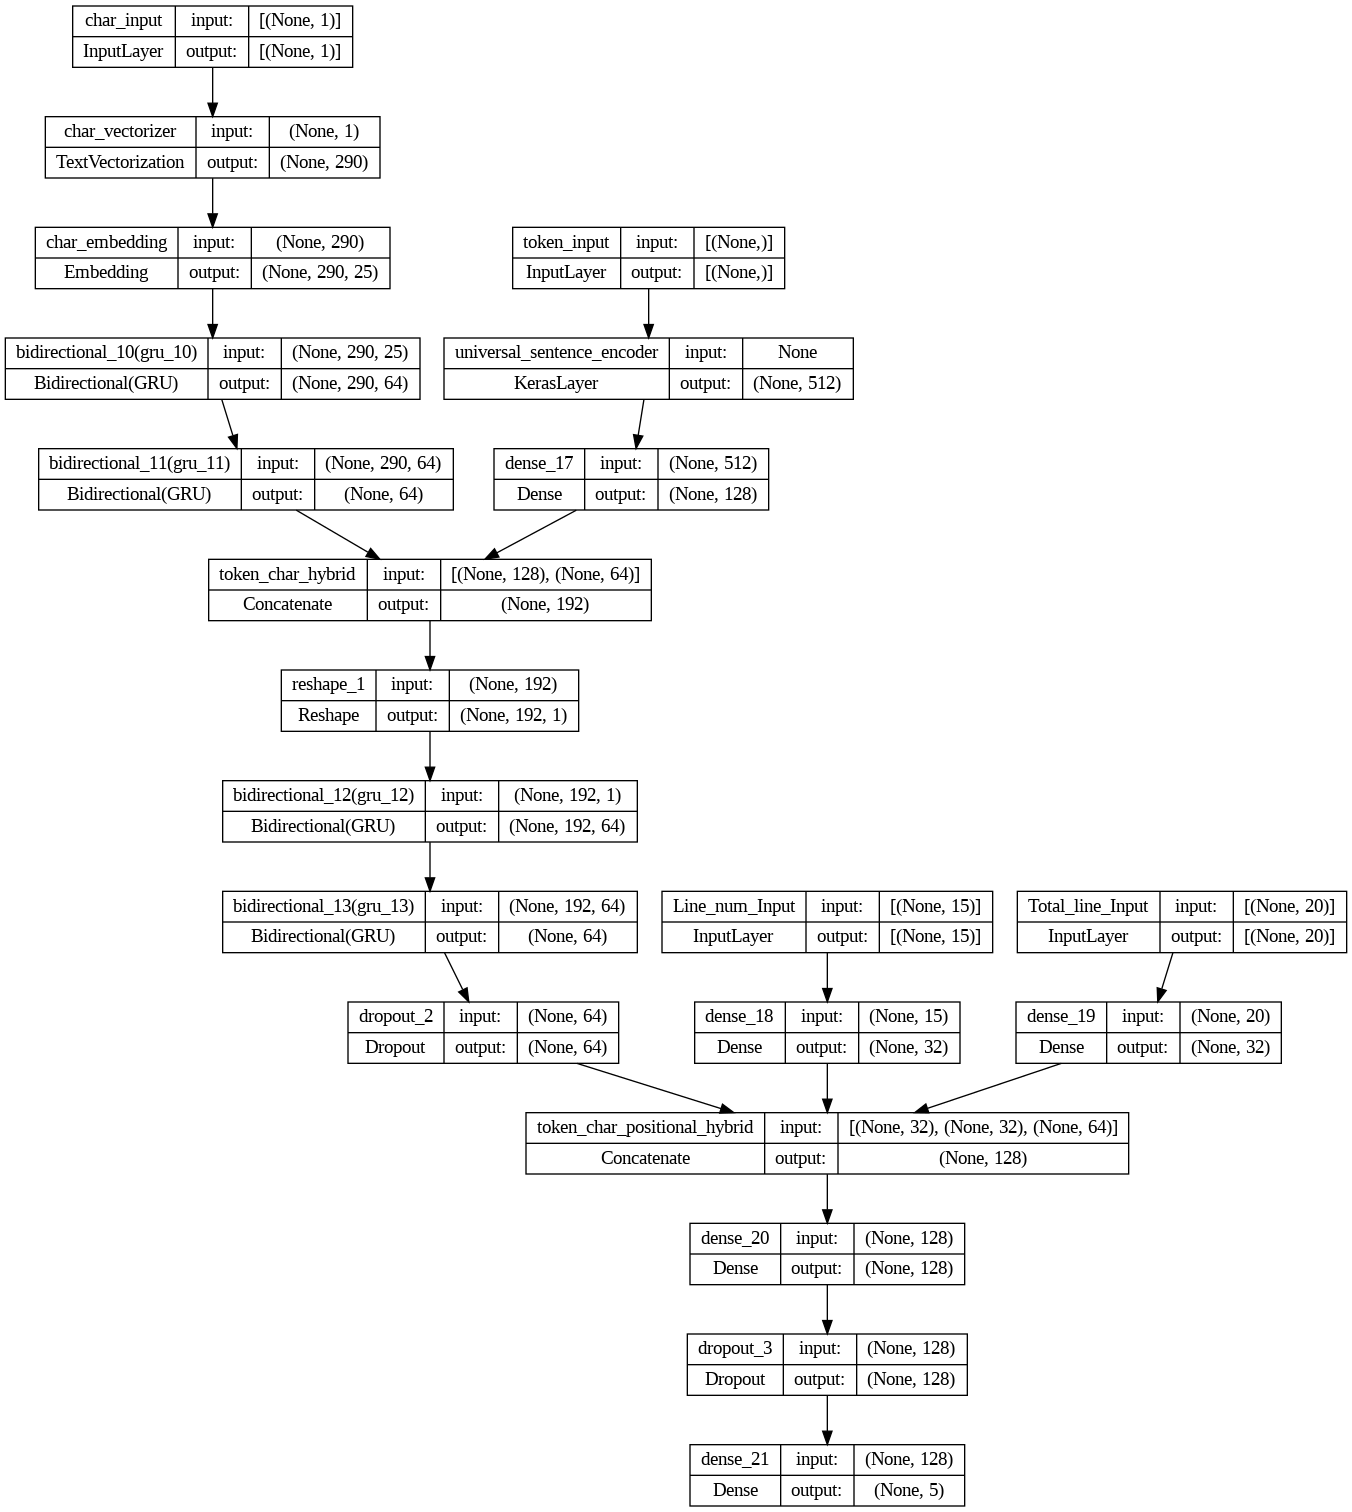

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model8,show_shapes=True)

In [ ]:
model8.summary()

Model: "Token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, 290, 25)      700         ['char_

**What is label smoothing?**

Label Smoothing is a regularization technique that introduces noise for the labels. This accounts for the fact that datasets may have mistakes in them.
It prevents overfitting of a neural network by softening the ground-truth labels in the training data in an attempt to penalize overconfident outputs.

In [ ]:
model8.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
# combines chars and tokens into the dataset
train_tribrid_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                       train_total_lines_one_hot,
                                                       train_sentences,
                                                       train_chars))
train_tribrid_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset=tf.data.Dataset.zip((train_tribrid_data,train_tribrid_labels))
# batch and prefetch
train_tribrid_dataset=train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




# combines chars and tokens into the dataset
val_tribrid_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                       val_total_lines_one_hot,
                                                       validation_sentences,
                                                       val_chars))
val_tribrid_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset=tf.data.Dataset.zip((val_tribrid_data,val_tribrid_labels))
# batch and prefetch
val_tribrid_dataset=val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)





# combines chars and tokens into the dataset
test_tribrid_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                       test_total_lines_one_hot,
                                                       test_sentences,
                                                       test_chars))
test_tribrid_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset=tf.data.Dataset.zip((test_tribrid_data,test_tribrid_labels))
# batch and prefetch
test_tribrid_dataset=test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_tribrid_dataset,val_tribrid_dataset,test_tribrid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history8=model8.fit(train_tribrid_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_tribrid_dataset)),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 150s 112ms/step - loss: 1.0864 - accuracy: 0.7239 - val_loss: 0.9515 - val_accuracy: 0.8105
Epoch 2/5
1125/1125 [==============================] - 113s 101ms/step - loss: 0.9747 - accuracy: 0.8102 - val_loss: 0.9220 - val_accuracy: 0.8338
Epoch 3/5
1125/1125 [==============================] - 111s 99ms/step - loss: 0.9567 - accuracy: 0.8219 - val_loss: 0.9086 - val_accuracy: 0.8388
Epoch 4/5
1125/1125 [==============================] - 121s 108ms/step - loss: 0.9372 - accuracy: 0.8355 - val_loss: 0.8929 - val_accuracy: 0.8504
Epoch 5/5
1125/1125 [==============================] - 117s 104ms/step - loss: 0.9335 - accuracy: 0.8392 - val_loss: 0.8898 - val_accuracy: 0.8564


In [ ]:
model8_pred_probs=model8.predict(val_tribrid_dataset)
model8_pred=tf.argmax(model8_pred_probs,axis=1)
model8_results=calculate_results(val_labels_encoded,model8_pred)

945/945 [==============================] - 41s 37ms/step


In [ ]:
model8_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model8_pred))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      3449
           1       0.93      0.82      0.87      4582
           2       0.89      0.90      0.90      9964
           3       0.81      0.49      0.61      2376
           4       0.86      0.91      0.88      9841

    accuracy                           0.85     30212
   macro avg       0.84      0.79      0.80     30212
weighted avg       0.86      0.85      0.85     30212



## Model 9: Using custom embedding & char embedding & postional embedding

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string,name='token_input')
token_text_vector=text_vectorizer(token_inputs)
token_embeddings=embedding(token_text_vector)
token_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,activation='tanh'))(token_embeddings)
token_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(token_bi_gru1)
atten_layer=AttentionLayer(name='attention_layer')
token_attention,atten_states=atten_layer([token_embeddings,token_bi_gru2])
token_concat_out = tf.keras.layers.Concatenate(axis=-1, name='token_concat_layer')([token_bi_gru2, token_attention])
token_bi_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh'))(token_concat_out)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_bi_gru3)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh'))(char_bi_gru1)
char_outputs=token_outputs=tf.keras.layers.Dense(128,activation='relu')(char_bi_gru2)
char_model=tf.keras.Model(char_inputs,char_outputs)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(64,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(64,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(256, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,activation='tanh'))(combined_bi_gru1)
combined_bi_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh'))(combined_bi_gru2)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru3)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
combined_dense2=tf.keras.layers.Dense(128,activation='relu')(combined_dense)
combined_dense3=tf.keras.layers.Dense(128,activation='relu')(combined_dense2)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense3)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model9=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

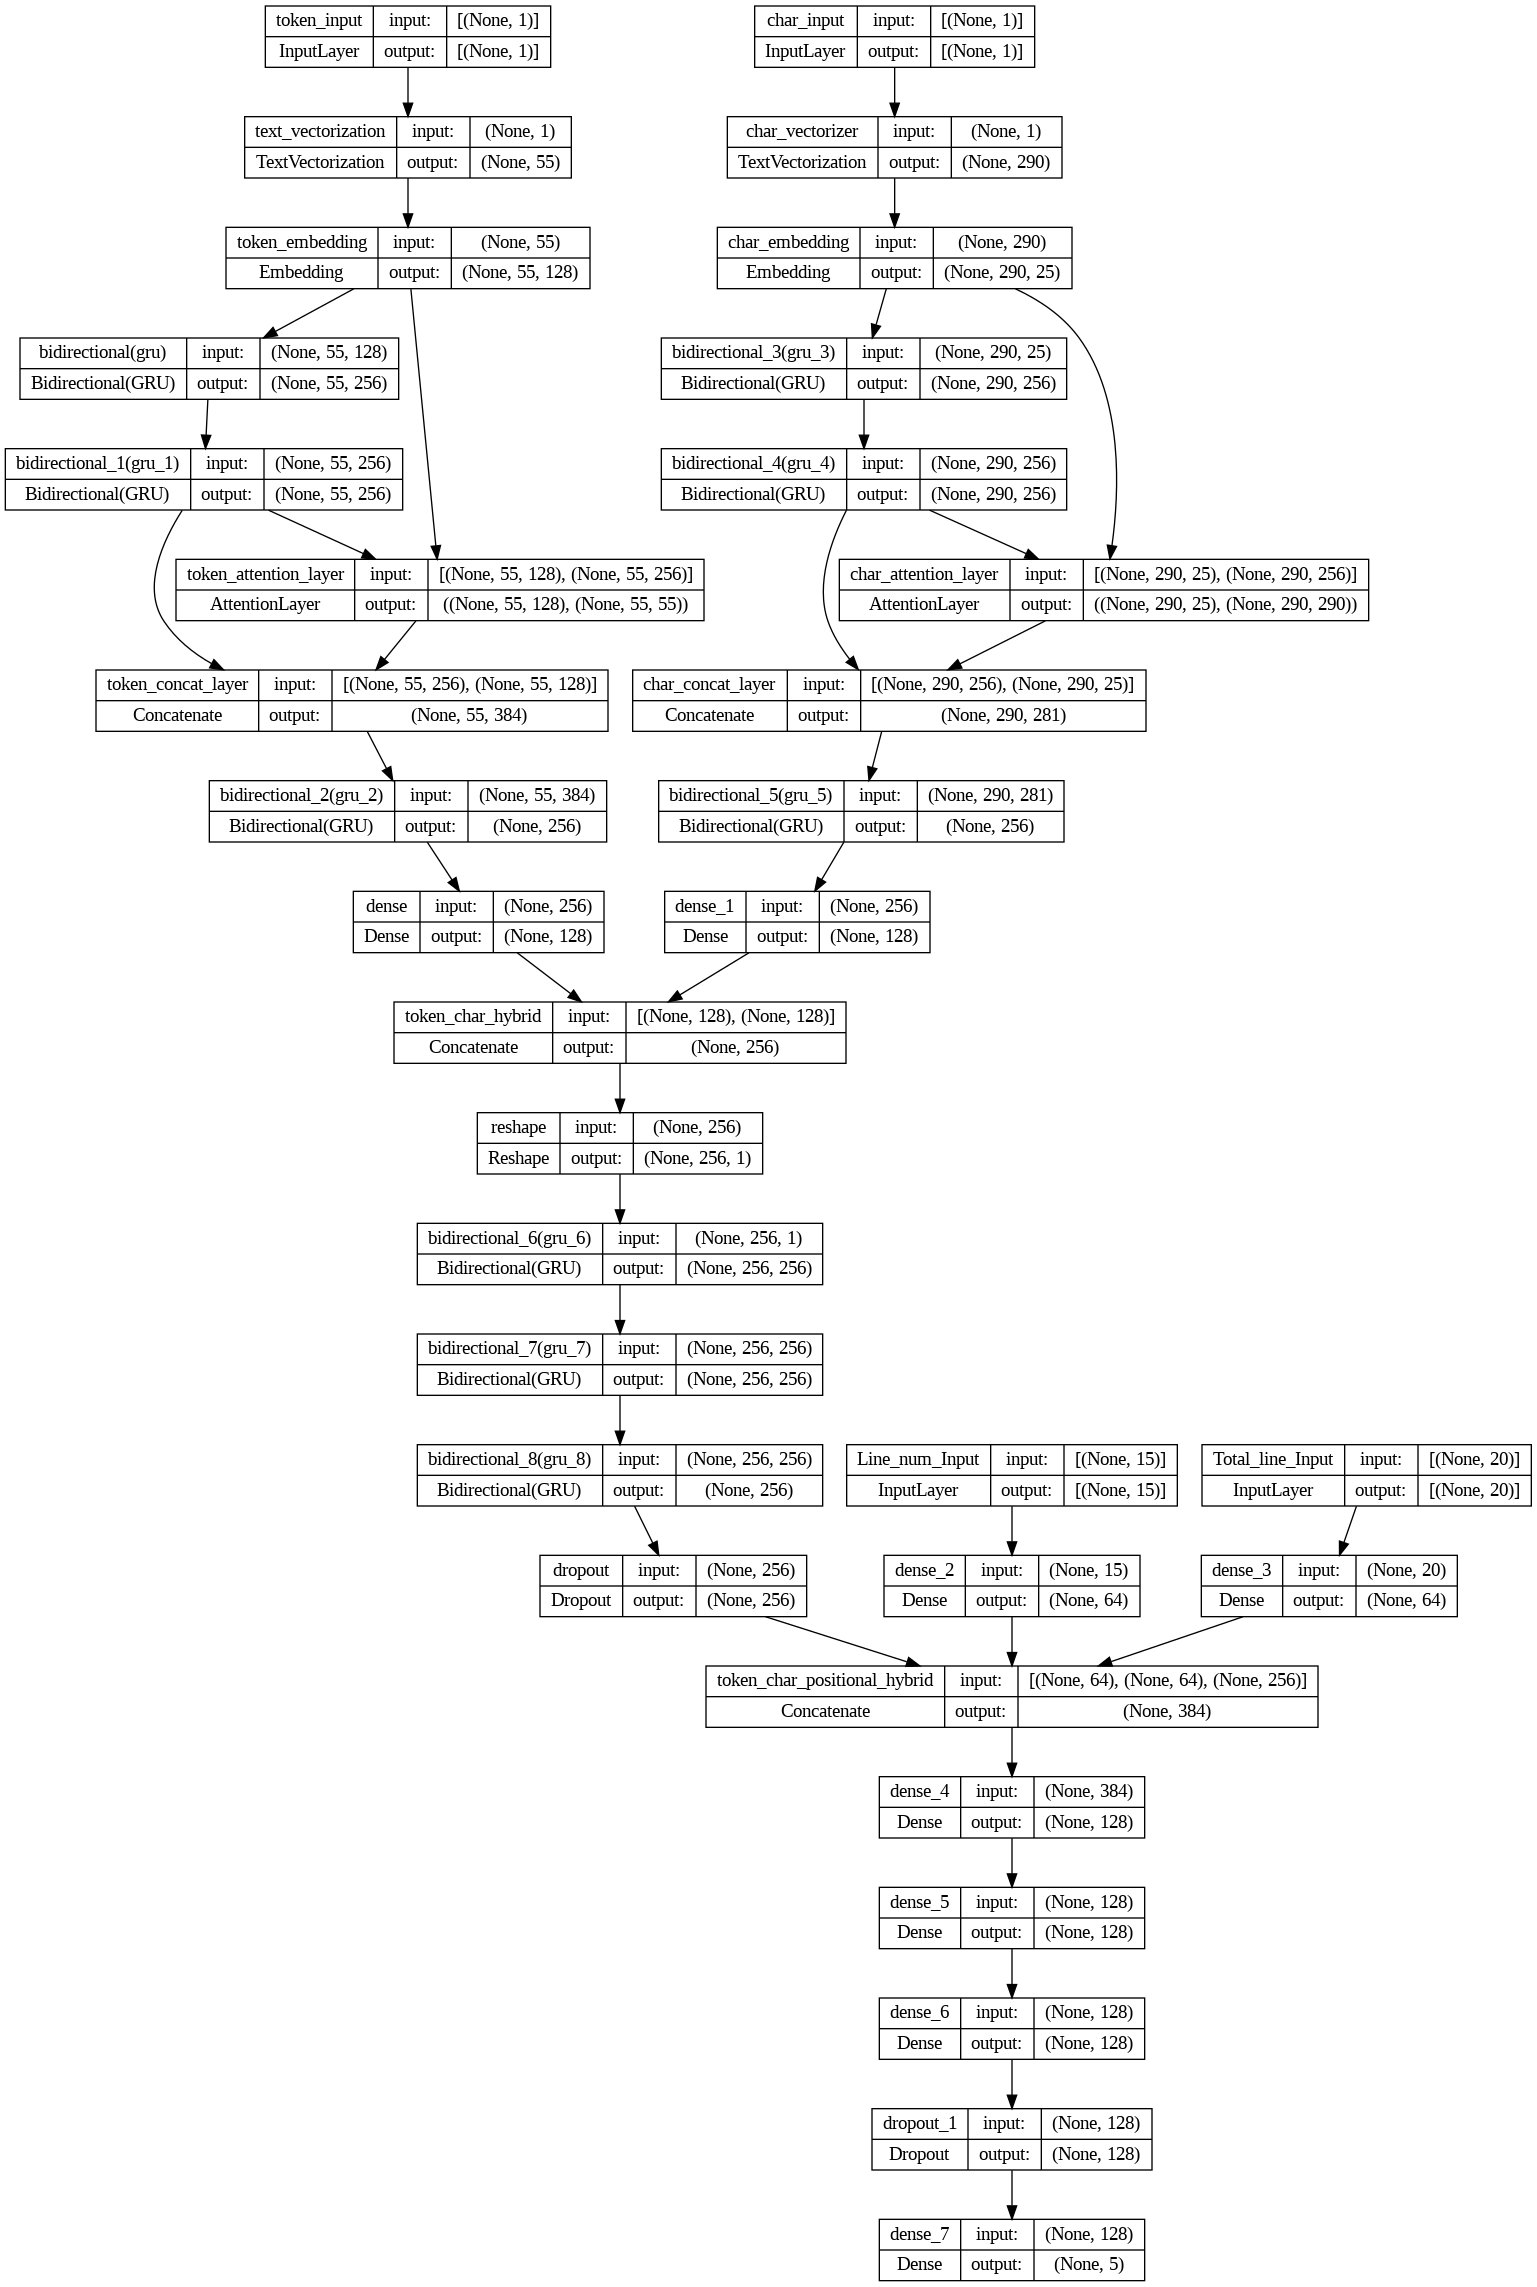

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model9,show_shapes=True)

In [ ]:
model9.summary()

Model: "Token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_

In [ ]:
model9.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)

In [ ]:
history9=model9.fit(train_tribrid_dataset,
                    epochs=100,
                    steps_per_epoch=int(0.05*len(train_tribrid_dataset)),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
281/281 [==============================] - 509s 2s/step - loss: 1.2829 - accuracy: 0.5508 - val_loss: 1.1559 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 2/100
281/281 [==============================] - 387s 1s/step - loss: 1.1705 - accuracy: 0.6380 - val_loss: 1.1141 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 3/100
281/281 [==============================] - 387s 1s/step - loss: 1.1372 - accuracy: 0.6650 - val_loss: 1.1026 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 4/100
281/281 [==============================] - 394s 1s/step - loss: 1.1204 - accuracy: 0.6844 - val_loss: 1.1042 - val_accuracy: 0.6749 - lr: 0.0010
Epoch 5/100
 49/281 [====>.........................] - ETA: 4:53 - loss: 1.1456 - accuracy: 0.6709

KeyboardInterrupt: ignored

In [ ]:
model9_pred_probs=model9.predict(val_tribrid_dataset)
model9_pred=tf.argmax(model9_pred_probs,axis=1)
model9_results=calculate_results(val_labels_encoded,model9_pred)

945/945 [==============================] - 85s 70ms/step


In [ ]:
model9_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model9_pred))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3449
           1       0.91      0.90      0.90      4582
           2       0.92      0.93      0.93      9964
           3       0.77      0.52      0.62      2376
           4       0.92      0.92      0.92      9841

    accuracy                           0.88     30212
   macro avg       0.85      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3449
           1       0.91      0.90      0.90      4582
           2       0.92      0.93      0.93      9964
           3       0.77      0.52      0.62      2376
           4       0.92      0.92      0.92      9841

    accuracy                           0.88     30212
   macro avg       0.85      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212



## Model 10: BERT & char embeddings & positional embeddings


In [ ]:
!pip uninstall -y -q tensorflow-text
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
import tensorflow_text
import tensorflow_hub as hub
preprocess_bert = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',trainable=False)

In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=(), dtype=tf.string,name='token_input')
token_preprocess = preprocess_bert(token_inputs)
token_bert = bert_encoder(token_preprocess, training=False)

token_pooled = token_bert['pooled_output']
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_pooled)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(char_bi_gru1)
char_model=tf.keras.Model(char_inputs,char_bi_gru2)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(32,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(192, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(combined_bi_gru1)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model10=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

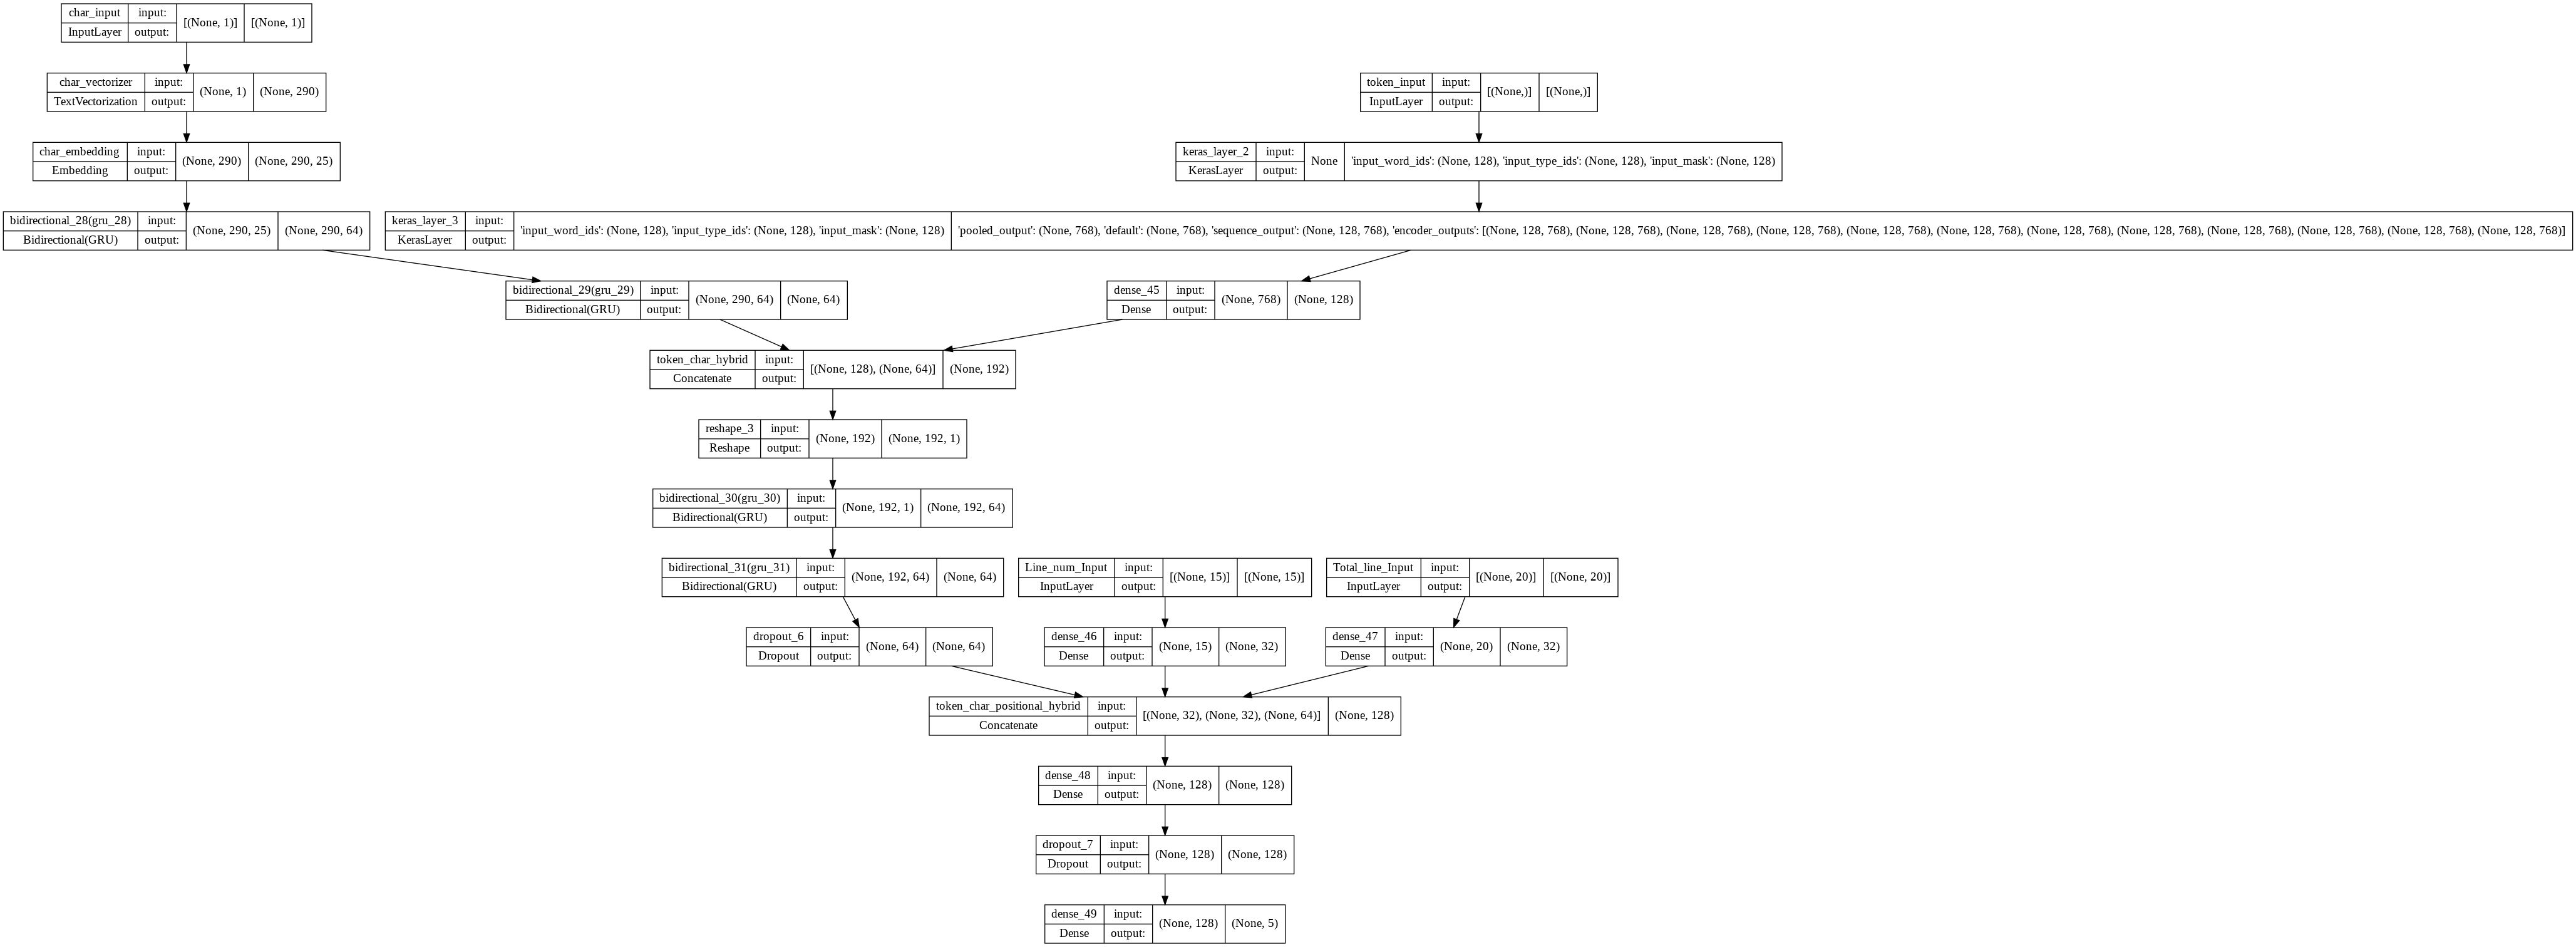

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model10,show_shapes=True)

In [ ]:
model10.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history10=model10.fit(train_tribrid_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.20*len(train_tribrid_dataset)),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 567s 481ms/step - loss: 0.9963 - accuracy: 0.8019 - val_loss: 0.8628 - val_accuracy: 0.8727
Epoch 2/5
 958/1125 [========================>.....] - ETA: 1:13 - loss: 0.9019 - accuracy: 0.8670

KeyboardInterrupt: ignored

In [ ]:
model10_pred_probs=model10.predict(val_tribrid_dataset)
model10_pred=tf.argmax(model10_pred_probs,axis=1)

In [ ]:
from helper_functions import calculate_results
model10_results=calculate_results(val_labels_encoded,model10_pred)

In [ ]:
model10_results

## Model 11: Training model 9 on full data

In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string,name='token_input')
token_text_vector=text_vectorizer(token_inputs)
token_embeddings=embedding(token_text_vector)
token_pooling=tf.keras.layers.GlobalMaxPooling1D()(token_embeddings)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_pooling)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(char_bi_gru1)
char_model=tf.keras.Model(char_inputs,char_bi_gru2)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(32,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(192, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(combined_bi_gru1)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model11=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

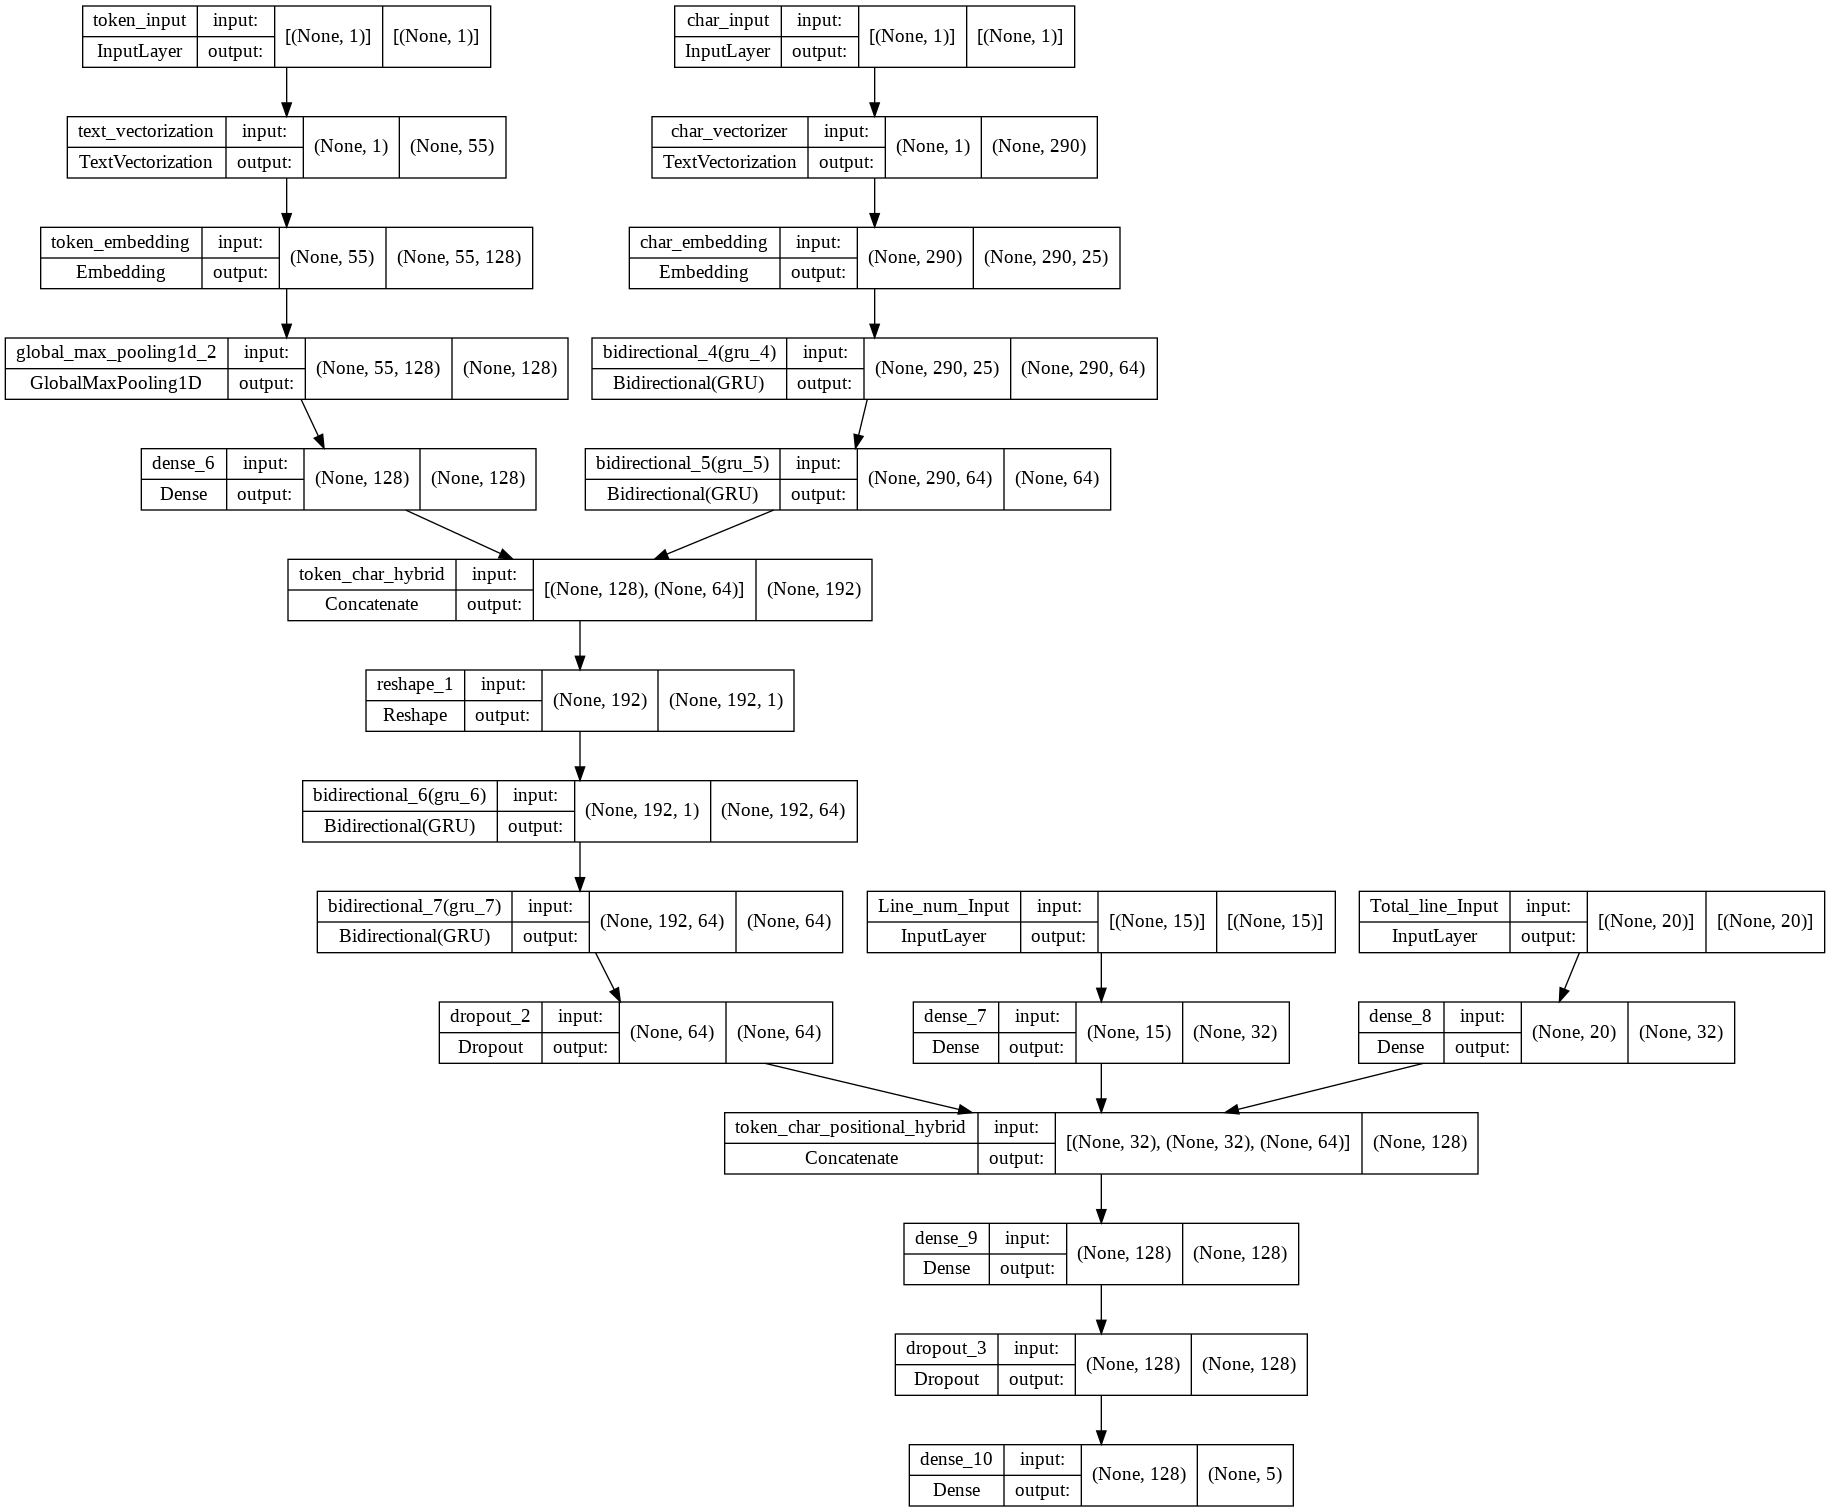

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model11,show_shapes=True)

In [ ]:
model11.summary()

Model: "Token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_

In [ ]:
model11.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)

In [ ]:
history11=model11.fit(train_tribrid_dataset,
                    epochs=100,
                    steps_per_epoch=len(train_tribrid_dataset),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
5627/5627 [==============================] - 538s 92ms/step - loss: 0.9229 - accuracy: 0.8502 - val_loss: 0.8708 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 500s 89ms/step - loss: 0.8600 - accuracy: 0.8900 - val_loss: 0.8847 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 3/100
5627/5627 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.9058
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5627/5627 [==============================] - 499s 89ms/step - loss: 0.8351 - accuracy: 0.9058 - val_loss: 0.8759 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 4/100
5627/5627 [==============================] - 500s 89ms/step - loss: 0.7979 - accuracy: 0.9311 - val_loss: 0.8807 - val_accuracy: 0.8620 - lr: 2.0000e-04


In [ ]:
model11_pred_probs=model11.predict(val_tribrid_dataset)
model11_pred=tf.argmax(model11_pred_probs,axis=1)
model11_results=calculate_results(val_labels_encoded,model11_pred)

In [ ]:
model11_results

{'accuracy': 85.99563087514895,
 'precision': 0.8582233917460073,
 'recall': 0.8599563087514894,
 'f1': 0.8587953627522987}

## Model12: Training model10 on full data

In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=(), dtype=tf.string,name='token_input')
token_preprocess = preprocess_bert(token_inputs)
token_bert = bert_encoder(token_preprocess, training=False)

token_pooled = token_bert['pooled_output']
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_pooled)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(char_bi_gru1)
char_model=tf.keras.Model(char_inputs,char_bi_gru2)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(32,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(192, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,activation='tanh'))(combined_bi_gru1)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model11=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

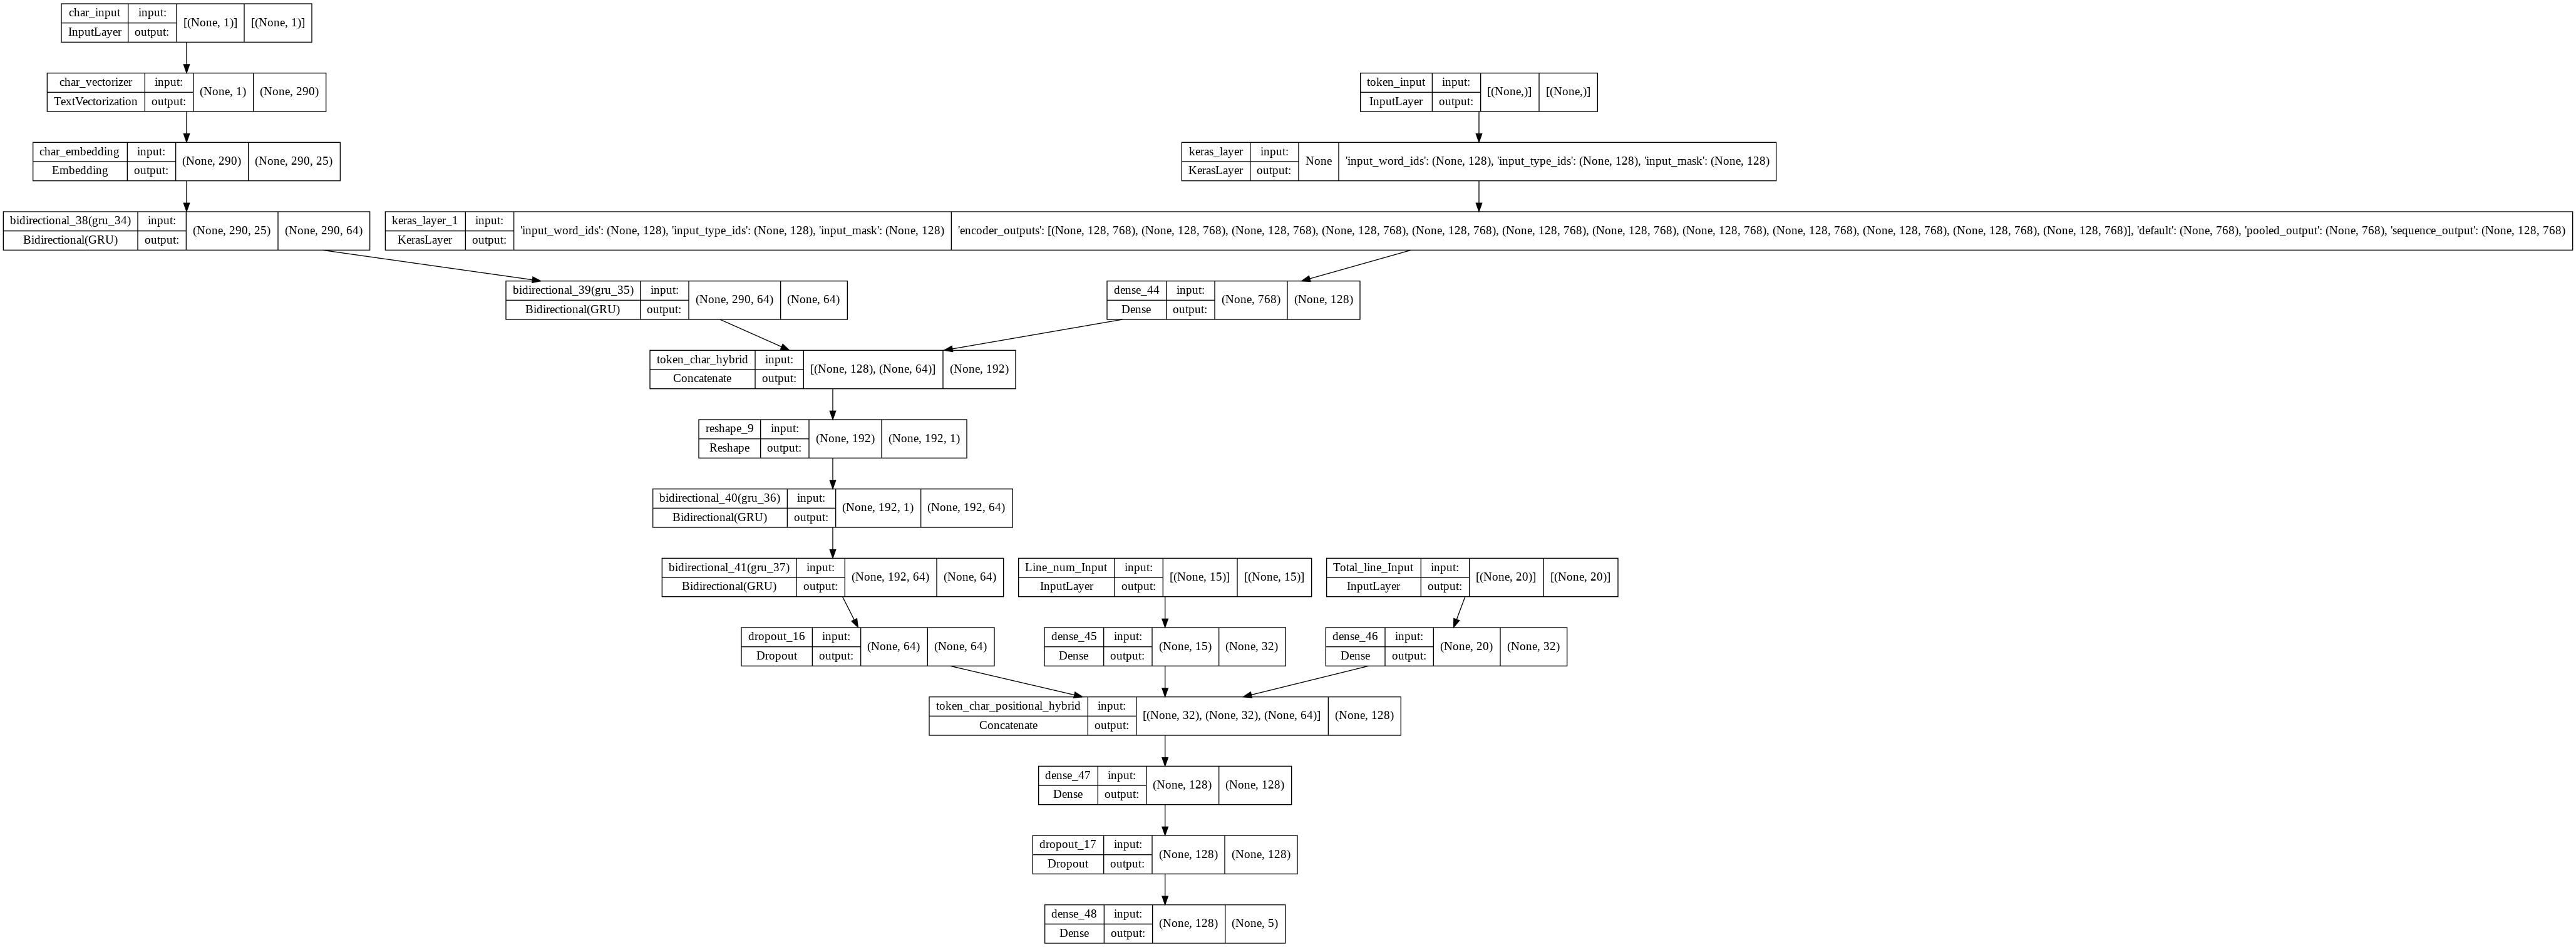

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model11,show_shapes=True)

In [ ]:
model11.summary()

Model: "Token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['token

In [ ]:
model11.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history11=model11.fit(train_tribrid_dataset,
                    epochs=100,
                    steps_per_epoch=len(train_tribrid_dataset),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
5627/5627 [==============================] - 2509s 440ms/step - loss: 0.9097 - accuracy: 0.8593 - val_loss: 0.8674 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 2429s 432ms/step - loss: 0.8643 - accuracy: 0.8867 - val_loss: 0.8545 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 3/100
3907/5627 [===================>..........] - ETA: 12:10 - loss: 0.8563 - accuracy: 0.8909

## Model 13: Using RCT 200K dataset with Model 9

### Loading and Preprocessing the RCT 200K data

In [ ]:
data_dir='pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
import zipfile as zip
data=zip.ZipFile(data_dir+'train.zip')
data.printdir()
data.extractall(data_dir)

File Name                                             Modified             Size
train.txt                                      2016-09-04 11:08:20    351658832


In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

def text_to_listdic(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()

      #Iterate through each line in a single abstract and count them
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split('\t')
        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1 #How many total line
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples


In [ ]:
test_text=text_to_listdic(data_dir+'test.txt')
validation_text=text_to_listdic(data_dir+'dev.txt')
train_text=text_to_listdic(data_dir+'train.txt')

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_text)
test_df=pd.DataFrame(test_text)
validation_df=pd.DataFrame(validation_text)

### Basic EDA

<Axes: ylabel='Frequency'>

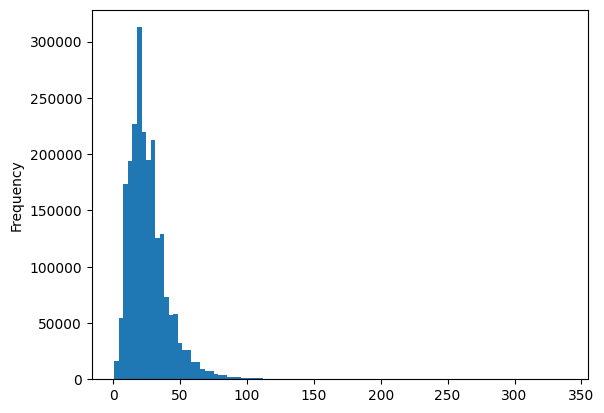

In [ ]:
train_df['text'].apply(lambda x:len(x.split())).plot.hist(bins=100)

In [ ]:
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

<Axes: >

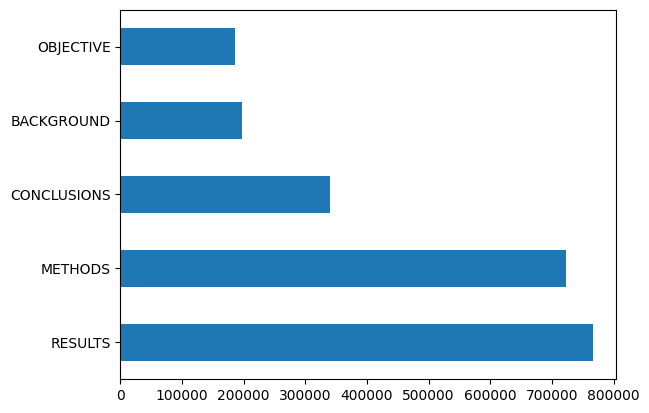

In [ ]:
train_df.target.value_counts().plot(kind='barh')

<Axes: ylabel='Frequency'>

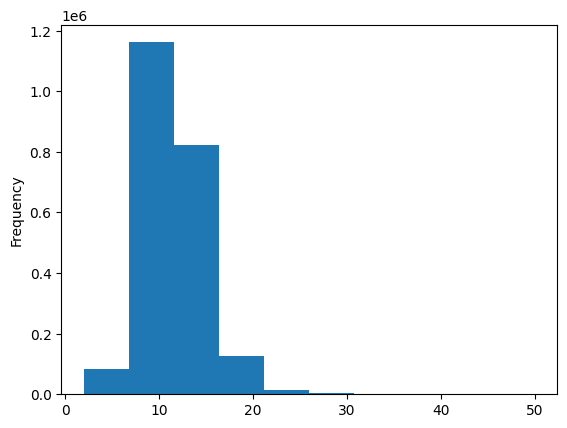

In [ ]:
# Let's check length of different lines
train_df.total_lines.plot.hist()

### Getting sentences and encoding

In [ ]:
train_sentences=train_df['text'].tolist()
test_sentences=test_df['text'].tolist()
validation_sentences=validation_df['text'].tolist()

In [ ]:
len(train_sentences),len(test_sentences),len(validation_sentences)

(2211861, 29493, 28932)

In [ ]:
# Onehot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False)  #don't want sparse matrix
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(validation_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

#Label encode Labels

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(validation_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())

# Get class
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from tensorflow.keras.layers import TextVectorization,Embedding
import numpy as np
import tensorflow as td

In [ ]:
sent_len=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_len)
avg_sent_len

26.229355280462922

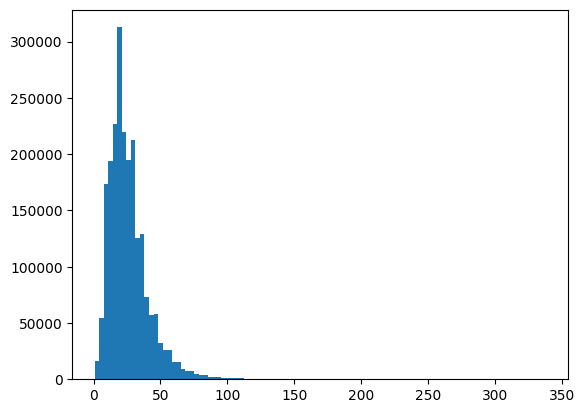

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_len,bins=100);

In [ ]:
#How long of a sentence length covers 95% of all of the sentences
output_seq_len=int(np.percentile(sent_len,95.5))
output_seq_len

55

This shows that 55 length covers 95% of the sentences

In [ ]:
#max sequence length
max_len=max(sent_len)
max_len

338

In [ ]:
max_tokens=100000
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  split='whitespace',
                                  ngrams=2,
                                  output_sequence_length=output_seq_len)

### Token Vectorization and Embedding

In [ ]:
import tensorflow as tf
train_data=tf.data.Dataset.from_tensor_slices(train_sentences)
train_data=train_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_data)

In [ ]:
rct_200k_text_vocab=text_vectorizer.get_vocabulary()

In [ ]:
len(rct_200k_text_vocab)

100000

In [ ]:
output_dim=128
embedding=Embedding(input_dim=len(rct_200k_text_vocab),output_dim=output_dim,
                    mask_zero=True,name='token_embedding')

### Character Vectorization and Embedding

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in validation_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_len=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_len)
mean_char_len

147.82646377869133

In [ ]:
output_seq_char_len=int(np.percentile(char_len,95))

In [ ]:
import string
import random
alphabet=string.ascii_lowercase+string.digits+string.punctuation
random.choice(train_sentences)

'our findings point to a possible effect of cbd in improving quality of life measures in pd patients with no psychiatric comorbidities ; however , studies with larger samples and specific objectives are required before definitive conclusions can be drawn .'

In [ ]:
num_char_tokens=len(alphabet) + 2

In [ ]:
char_vectorizer=TextVectorization(max_tokens=num_char_tokens,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [ ]:
train_char_data=tf.data.Dataset.from_tensor_slices(train_chars)
train_char_data=train_char_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
char_vectorizer.adapt(train_char_data)

In [ ]:
char_vocab=char_vectorizer.get_vocabulary()

In [ ]:
output_dim=25
char_embedding=Embedding(input_dim=len(char_vocab),
                         output_dim=output_dim,
                         mask_zero=True,
                         name='char_embedding')

### Positional Embedding

<Axes: ylabel='Frequency'>

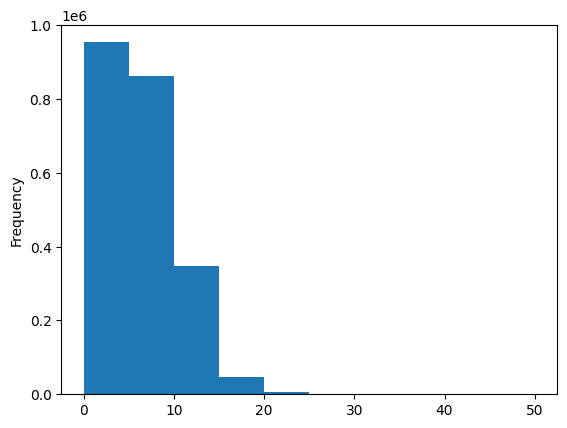

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
depth_linenum=int(np.percentile(train_df['line_number'],98))

In [ ]:
# Use tensorflow to create One-hot-encoded tensors for line number
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=depth_linenum)
val_line_numbers_one_hot=tf.one_hot(validation_df['line_number'].to_numpy(),depth=depth_linenum)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=depth_linenum)

<Axes: ylabel='Frequency'>

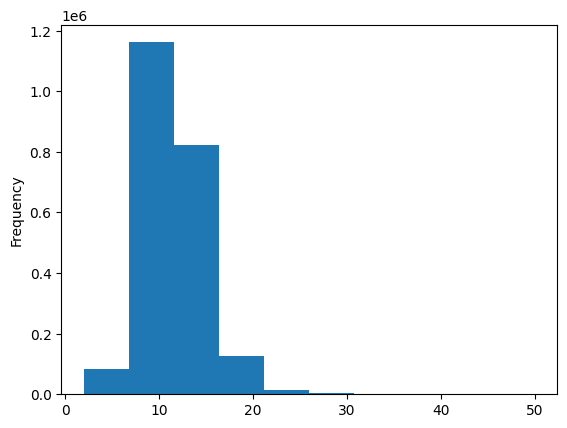

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
depth_total_lines=int(np.percentile(train_df['total_lines'],98))

In [ ]:
# Use tensorflow to create One-hot-encoded tensors for total lines
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=depth_total_lines)
val_total_lines_one_hot=tf.one_hot(validation_df['total_lines'].to_numpy(),depth=depth_total_lines)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=depth_total_lines)

### Tribrid Dataset

In [ ]:
# combines chars and tokens into the dataset
train_tribrid_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                       train_total_lines_one_hot,
                                                       train_sentences,
                                                       train_chars))
train_tribrid_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset=tf.data.Dataset.zip((train_tribrid_data,train_tribrid_labels))
# batch and prefetch
train_tribrid_dataset=train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# combines chars and tokens into the dataset
val_tribrid_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                       val_total_lines_one_hot,
                                                       validation_sentences,
                                                       val_chars))
val_tribrid_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset=tf.data.Dataset.zip((val_tribrid_data,val_tribrid_labels))
# batch and prefetch
val_tribrid_dataset=val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



# combines chars and tokens into the dataset
test_tribrid_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                       test_total_lines_one_hot,
                                                       test_sentences,
                                                       test_chars))
test_tribrid_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset=tf.data.Dataset.zip((test_tribrid_data,test_tribrid_labels))
# batch and prefetch
test_tribrid_dataset=test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model13: Training model 9 on RCT200k

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# 1. Setup token input/model
token_inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string,name='token_input')
token_text_vector=text_vectorizer(token_inputs)
token_embeddings=embedding(token_text_vector)
token_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,activation='tanh'))(token_embeddings)
token_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(token_bi_gru1)
atten_layer=AttentionLayer(name='attention_layer')
token_attention,atten_states=atten_layer([token_embeddings,token_bi_gru2])
token_concat_out = tf.keras.layers.Concatenate(axis=-1, name='token_concat_layer')([token_bi_gru2, token_attention])
token_bi_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh'))(token_concat_out)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_bi_gru3)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char inputs/model
char_inputs=tf.keras.layers.Input(dtype=tf.string,shape=(1,),name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeds=char_embedding(char_vectors)
char_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(char_embeds)
char_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(char_bi_gru1)
char_model=tf.keras.Model(char_inputs,char_bi_gru2)

# 3. Setup line number model
line_num_inputs=tf.keras.layers.Input(shape=(15,),dtype=tf.float32,name='Line_num_Input')
line_num_outputs=tf.keras.layers.Dense(32,activation='relu')(line_num_inputs)
line_num_model=tf.keras.Model(line_num_inputs,line_num_outputs)

# 4. Setup total lines model
total_line_inputs=tf.keras.layers.Input(shape=(20,),dtype=tf.float32,name='Total_line_Input')
total_line_outputs=tf.keras.layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(total_line_inputs,total_line_outputs)

# 5. Concatenate Token and char inputs (hybrid token embedding)
token_char_concat= tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                          char_model.output])
# 6. Adding Bidirectional GRU layers on top of it.
reshaped = tf.keras.layers.Reshape(target_shape=(256, 1))(token_char_concat)
combined_bi_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,activation='tanh'))(reshaped)
combined_bi_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_bi_gru1)

# 7. Dropout layer
combined_dropout= tf.keras.layers.Dropout(0.5)(combined_bi_gru2)

# 8. Concatenate 5 & 4 & 3
tribrid_embeddings= tf.keras.layers.Concatenate(name='token_char_positional_hybrid')([line_num_model.output,
                                                                                    total_line_model.output,
                                                                                    combined_dropout])
# 9. Creating output layers - adding dropout
combined_dense=tf.keras.layers.Dense(128,activation='relu')(tribrid_embeddings)
final_dropout=tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

# 10. Construct model with char and token inputs
model13=tf.keras.Model(inputs=[line_num_model.input,total_line_model.input,token_model.input,char_model.input],
                      outputs=output_layer,
                      name='Token_char_positional_model')

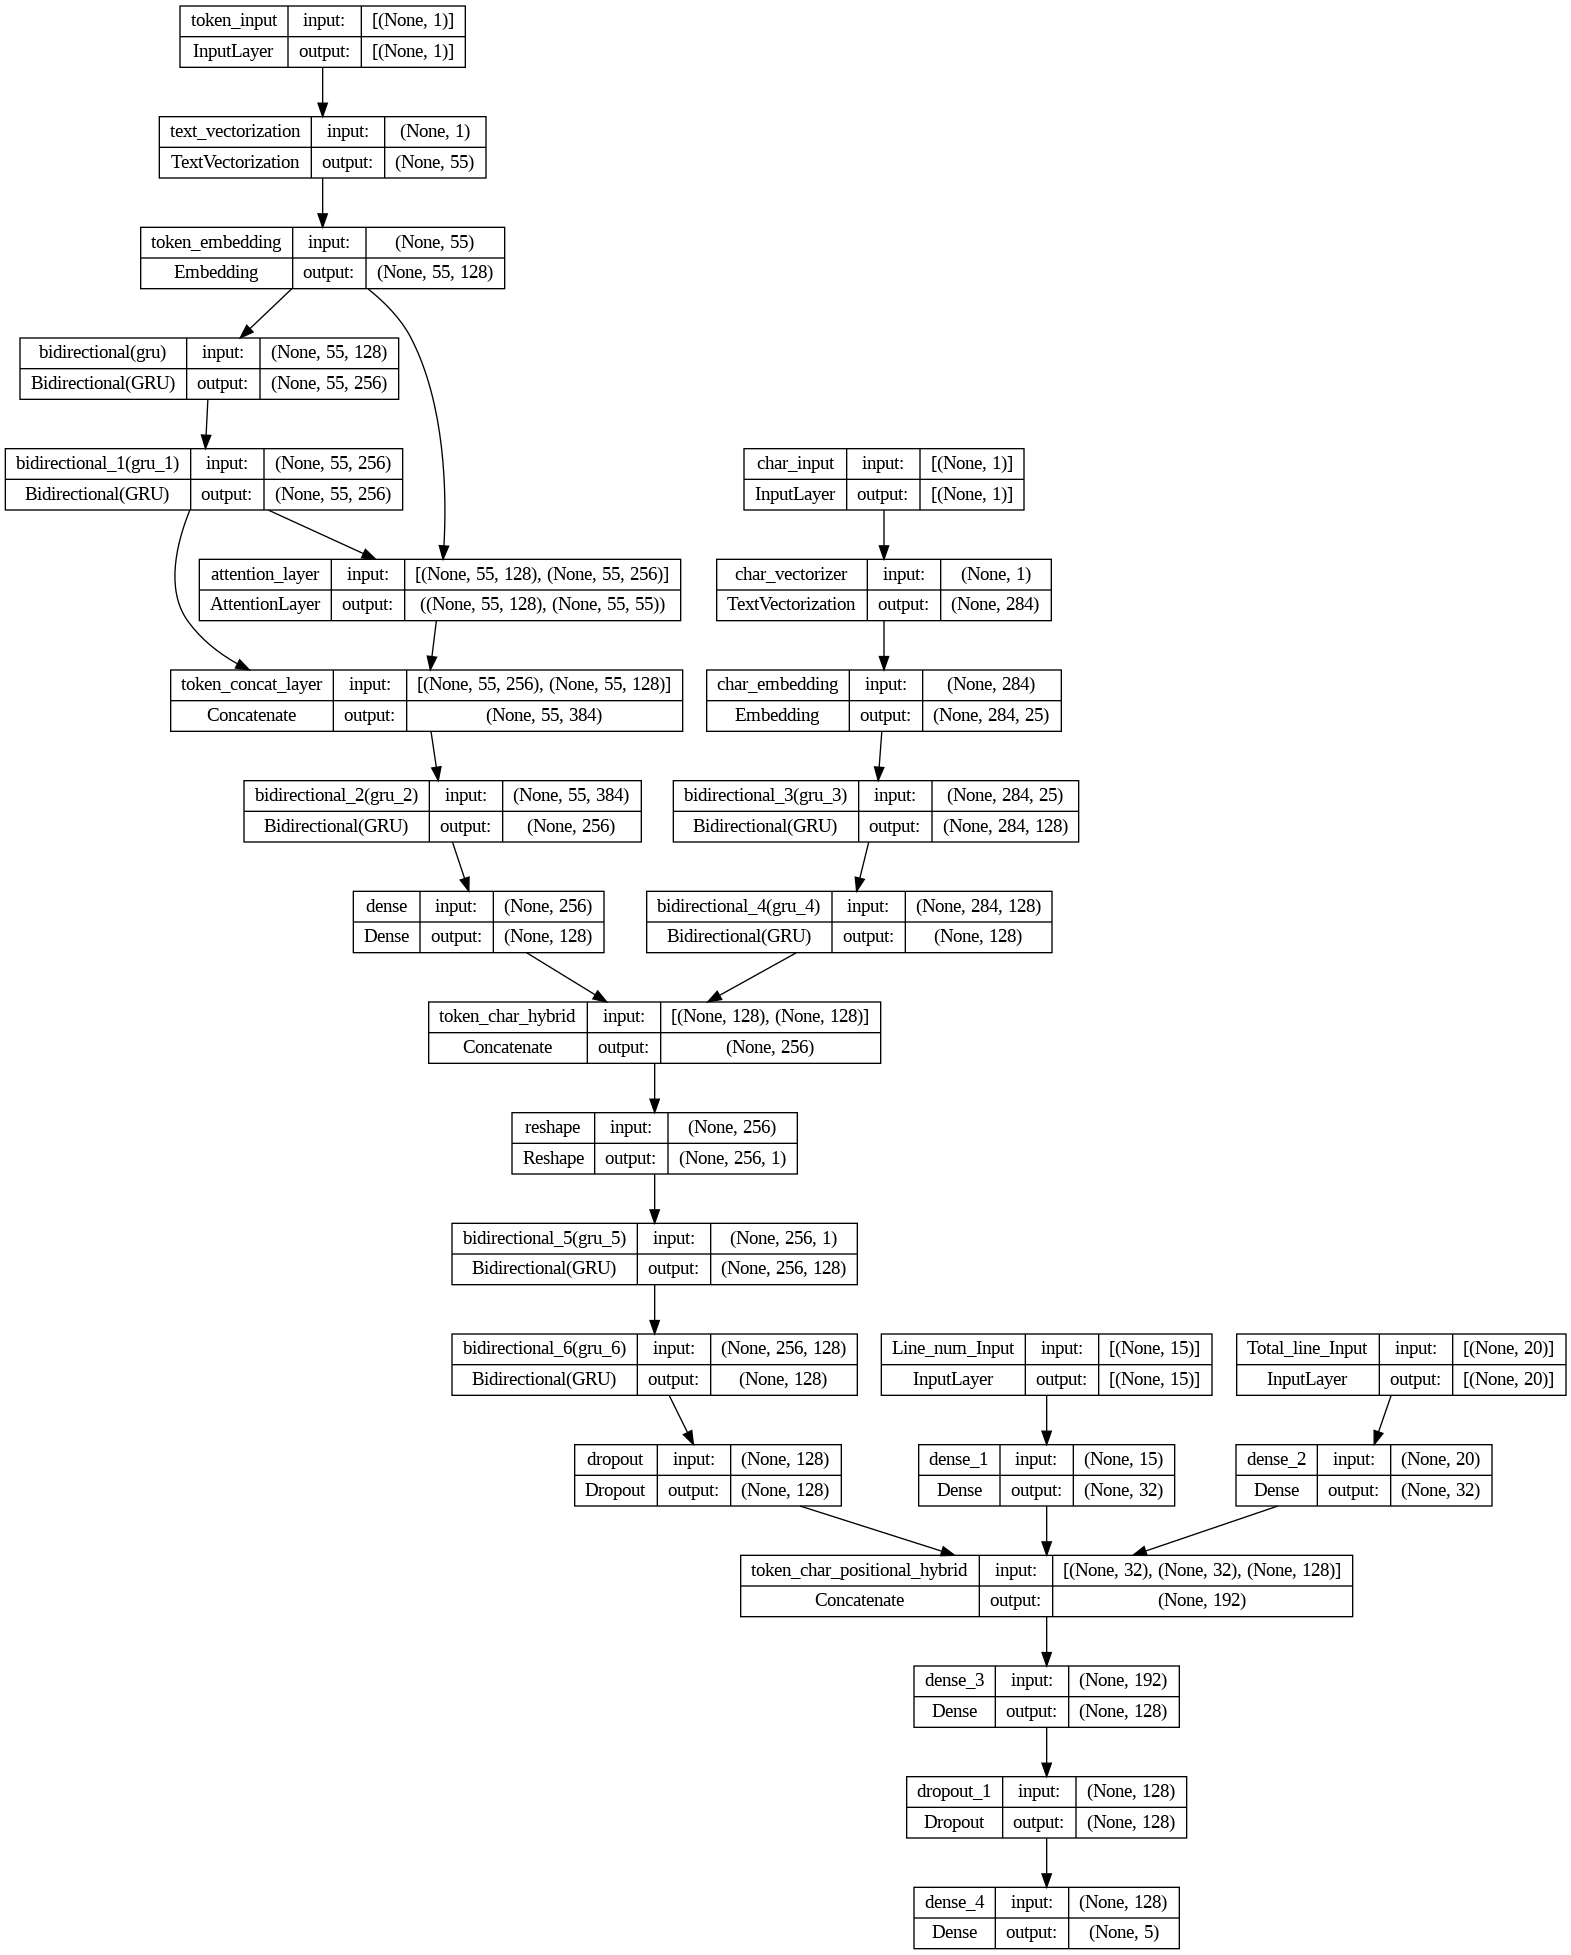

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model13,show_shapes=True)

In [ ]:
model13.summary()

Model: "Token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      12800000    ['text_vectorization[0][0]']     
                                                                                                  
 bidirectional (Bidirectional)  (None, 55, 256)      198144      ['token

In [ ]:
model13.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)

In [ ]:
history13=model13.fit(train_tribrid_dataset,
                    epochs=100,
                    steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                    validation_data=val_tribrid_dataset,
                    validation_steps=int(0.1*len(val_tribrid_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
6912/6912 [==============================] - 2614s 369ms/step - loss: 0.9240 - accuracy: 0.8401 - val_loss: 0.8490 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 2/100
1144/6912 [===>..........................] - ETA: 34:27 - loss: 0.8729 - accuracy: 0.8765

In [ ]:
model13_pred_probs=model13.predict(val_tribrid_dataset)
model13_pred=tf.argmax(model13_pred_probs,axis=1)

In [ ]:
from helper_functions import calculate_results
model13_results=calculate_results(val_labels_encoded,model13_pred)
model13_results

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels_encoded,model13_pred))